# Analyze AFM tip solvation

This notebook demonstrates deposition of an SDS adsorption layer on a non-spherical AFM tip model.

## Initialization

### IPython magic

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



### Imports

In [2]:
import ase.io # here used for reading pdb files
from ase.visualize import view
from ase.visualize.plot import plot_atoms # has nasty offset issues
from cycler import cycler # here used for cycling through colors in plots
import datetime
import fabric # for pythonic ssh connections
from fireworks import LaunchPad, Firework, Tracker, Workflow 
from fireworks import FileTransferTask, PyTask, ScriptTask

# FireWorks functionality 
from fireworks import Firework, LaunchPad, ScriptTask, Workflow
from fireworks.user_objects.firetasks.templatewriter_task import TemplateWriterTask
from fireworks.user_objects.firetasks.filepad_tasks import AddFilesTask, GetFilesTask, GetFilesByQueryTask
from imteksimfw.fireworks.user_objects.firetasks.cmd_tasks import CmdTask
from fireworks.utilities.filepad import FilePad # direct FilePad access, similar to the familiar LaunchPad

from collections.abc import Iterable
import glob
import gc # manually clean up memory with gc.collect()
import gromacs # GromacsWrapper, here used for evoking gmc commands, reading and writing .ndx files
# from io import StringIO, TextIOWrapper
import io
from IPython.display import display, Image #, Video # display image files within notebook
from ipywidgets import Video  # display video within notebook
import itertools # for products of iterables
import json # generic serialization of lists and dicts
import jinja2 # here used for filling packmol input script template
import jinja2.meta # for gathering variables in a jinja2 template
import logging 
import matplotlib.pyplot as plt
import MDAnalysis as mda # here used for reading and analyzing gromacs trajectories
import MDAnalysis.analysis.rdf as mda_rdf
import MDAnalysis.analysis.rms as mda_rms
from mpl_toolkits.mplot3d import Axes3D # here used for 3d point cloud scatter plot
import miniball # finds minimum bounding sphere of a point set
import nglview
import numpy as np
import os, os.path
import pandas as pd
import panedr # reads GROMACS edr into pandas df, requires pandas and pbr
import parmed as pmd # has quite a few advantages over ASE when it comes to parsing pdb
from pprint import pprint
import pymongo # for sorting in queries
import scipy.constants as sc
import subprocess # used for evoking external packmol
import sys
import tempfile
import yaml

NOTE: Some configuration directories are not set up yet: 
	/home/centos/.gromacswrapper
	/home/centos/.gromacswrapper/qscripts
	/home/centos/.gromacswrapper/templates
NOTE: You can create the configuration file and directories with:
	>>> import gromacs
	>>> gromacs.config.setup()


GromacsWrapper might need a file `~/.gromacswrapper.cfg` with content
```cfg
[Gromacs]
tools = gmx gmx_d 
# gmx_mpi_d gmx_mpi_d

# name of the logfile that is written to the current directory
logfilename = gromacs.log

# loglevels (see Python's logging module for details)
#   ERROR   only fatal errors
#   WARN    only warnings
#   INFO    interesting messages
#   DEBUG   everything

# console messages written to screen
loglevel_console = INFO

# file messages written to logfilename
loglevel_file = DEBUG
```
in order to know the GROMACS executables it is allowed to use. Otherwise,
calls to `gmx_mpi` or `gmx_mpi_d` without MPI wrapper might lead to MPI 
warnings in output that cause GromacsWrapper to fail.

### Logging

In [3]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()
logger.setLevel(logging.INFO)

ParmEd needs to know the GROMACS topology folder, usually get this from 
envionment variable `GMXLIB`:

### Function definitions

In [4]:
def find_undeclared_variables(infile):
    """identify all variables evaluated in a jinja 2 template file"""
    env = jinja2.Environment()
    with open(infile) as template_file:
        parsed = env.parse(template_file.read())

    undefined = jinja2.meta.find_undeclared_variables(parsed)
    return undefined

In [5]:
def memuse():
    """Quick overview on memory usage of objects in Jupyter notebook"""
    # https://stackoverflow.com/questions/40993626/list-memory-usage-in-ipython-and-jupyter
    # These are the usual ipython objects, including this one you are creating
    ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

    # Get a sorted list of the objects and their sizes
    return sorted([(x, sys.getsizeof(globals().get(x))) for x in dir(sys.modules['__main__']) if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

### Global settings

In [19]:
# pandas settings
pd.options.display.max_rows = 200
pd.options.display.max_columns = 16
pd.options.display.max_colwidth = 256

In [6]:
os.environ['GMXLIB'] = '/gmx_top'

In [7]:
# pmd.gromacs.GROMACS_TOPDIR = os.environ['GMXLIB']
pmd.gromacs.GROMACS_TOPDIR = '/gmx_top'

In [8]:
# prefix = '/mnt/dat/work/testuser/indenter/sandbox/20191110_packmol'
prefix = '/mnt/dat/work'

In [9]:
work_prefix = '/mnt/dat/work/tmp'

In [10]:
try:
    os.mkdir(work_prefix)
except FileExistsError as exc:
    print(exc)

[Errno 17] File exists: '/mnt/dat/work/tmp'


In [11]:
os.chdir(work_prefix)

In [12]:
# the FireWorks LaunchPad
lp = LaunchPad.auto_load() #Define the server and database
# FilePad behaves analogous to LaunchPad
fp = FilePad.auto_load()

## Conversion from LAMMPS data format to PDB

The following bash / tcl snippet converts a LAMMPS data file to PDB, assigning the desired names as mapped in a yaml file
```bash
#!/bin/bash
# echo "package require jlhvmd; jlh lmp2pdb indenter.lammps indenter.pdb" | vmd -eofexit
vmd -eofexit << 'EOF'
package require jlhvmd
topo readlammpsdata indenter.lammps
jlh type2name SDS_type2name.yaml
jlh name2res  SDS_name2res.yaml
set sel [atomselect top all]
$sel writepdb indenter.pdb
EOF

pdb_chain.py indenter.pdb > indenter_wo_chainid.pdb
pdb_reres_by_atom_9999.py indenter_wo_chainid.pdb > indenter_reres.pdb
```

Requires

* VMD (tested with 1.9.3) with topotools
* jlhvmd VMD plugin: https://github.com/jotelha/jlhvmd
* pdb-tools: https://github.com/haddocking/pdb-tools/

## Overview

### Overview on projects in database

In [13]:
query = {'metadata.datetime': {'$gt': '2020'} }

In [14]:
fp.filepad.count_documents(query)

807

In [15]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 'project': '$metadata.project' },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # pull 'project' field up in hierarchy
        "$addFields": { 
            "project": "$_id.project",
        },
    },
    {  # drop nested '_id.project'
        "$project": { 
            "_id": False 
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

# sort_aggregation
#aggregation_pipeline = [ match_aggregation, group_aggregation, set_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [c for c in cursor]
res_df = pd.DataFrame(data=res) # pandas Dataframe is just nice for printing in notebook

In [16]:
res_df

object_count                    earliest                      latest  \
0            80  2020-08-24 17:48:58.997210  2020-08-24 20:24:33.489028   
1           432  2020-07-29 03:50:20.485949  2020-07-29 03:50:22.884335   
2           295  2020-07-29 03:47:40.301419  2020-07-29 03:47:42.358240   

                                          project  
0  2020-08-24-au-111-fcc-substrate-creation-trial  
1  2020-07-29-ctab-on-au-111-indenter-passivation  
2   2020-07-29-sds-on-au-111-indenter-passivation

### Overview on steps in project

In [17]:
project_id = '2020-07-29-ctab-on-au-111-indenter-passivation'

In [18]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [19]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

432

In [20]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [21]:
res_df

step  \
0  GromacsNPTEquilibration:ProcessAnalyzeAndVisua...   
1  GromacsNVTEquilibration:ProcessAnalyzeAndVisua...   
2  GromacsEnergyMinimizationAfterSolvation:Proces...   
3  GromacsRelaxation:ProcessAnalyzeAndVisualize:p...   

                     earliest                      latest  object_count  
0  2020-07-29 03:50:22.175126  2020-07-29 03:50:22.175177            21  
1  2020-07-29 03:50:22.162719  2020-07-29 03:50:22.162768            21  
2  2020-07-29 03:50:22.148492  2020-07-29 03:50:22.148542            20  
3  2020-07-29 03:50:20.485949  2020-07-29 03:50:22.884335           370

In [22]:
res_df['step'].values

array(['GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',
       'GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad'],
      dtype=object)

### Overview on objects in project

In [23]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
}

In [24]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

92

In [25]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'step', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [26]:
res_df

type                                               step  \
0               mp4_file  GromacsEnergyMinimizationAfterSolvation:Proces...   
1   surfactant_tail_rmsd  GromacsEnergyMinimizationAfterSolvation:Proces...   
2   surfactant_head_rmsd  GromacsEnergyMinimizationAfterSolvation:Proces...   
3         substrate_rmsd  GromacsEnergyMinimizationAfterSolvation:Proces...   
4        counterion_rmsd  GromacsEnergyMinimizationAfterSolvation:Proces...   
..                   ...                                                ...   
87              template            SphericalSurfactantPacking:push_infiles   
88                 input  GromacsEnergyMinimization:GromacsTrajectoryVis...   
89       counterion_file            SphericalSurfactantPacking:push_infiles   
90                 input  GromacsEnergyMinimizationAfterSolvation:Gromac...   
91                 input  GromacsEnergyMinimization:GromacsTrajectoryVis...   

                   name                    earliest  \
0                   NaN  2020-07-29 02:01:24.379766   
1                   NaN  2020-07-29 02:01:24.379763   
2                   NaN  2020-07-29 02:01:24.379761   
3                   NaN  2020-07-29 02:01:24.379758   
4                   NaN  2020-07-29 02:01:24.379756   
..                  ...                         ...   
87  sphere.inp.template                        None   
88   movie.pml.template                        None   
89             1_BR.pdb                        None   
90      em_solvated.mdp                        None   
91      renumber_png.sh                        None   

                        latest  object_count  
0   2020-07-29 02:01:24.379766             1  
1   2020-07-29 02:01:24.379763             1  
2   2020-07-29 02:01:24.379761             1  
3   2020-07-29 02:01:24.379758             1  
4   2020-07-29 02:01:24.379756             1  
..                         ...           ...  
87                        None             1  
88                        None             1  
89                        None             1  
90                        None             1  
91                        None             1  

[92 rows x 6 columns]

### Overview on images by distinct steps

In [27]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
}

In [28]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

4

In [29]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [30]:
res_df

step      type  name  \
0  SphericalSurfactantPacking:ProcessAnalyzeAndVi...  png_file   NaN   
1  PackingConstraintSpheres:ProcessAnalyzeAndVisu...  png_file   NaN   
2  SurfactantMoleculeMeasures:ProcessAnalyzeAndVi...  png_file   NaN   
3  IndenterBoundingSphere:ProcessAnalyzeAndVisual...  png_file   NaN   

                     earliest                      latest  object_count  
0  2020-07-29 02:01:24.348488  2020-07-29 02:01:24.348488             1  
1  2020-07-29 02:01:24.316363  2020-07-29 02:01:24.316363             1  
2  2020-07-29 02:01:24.288177  2020-07-29 02:01:24.288177             1  
3  2020-07-29 02:01:24.236780  2020-07-29 02:01:24.236780             1

In [31]:
res_df["step"][0]

'SphericalSurfactantPacking:ProcessAnalyzeAndVisualize:push_filepad'

## Packing visualization

### Indenter bounding sphere

In [32]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'IndenterBoundingSphere'}
}

In [33]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [34]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

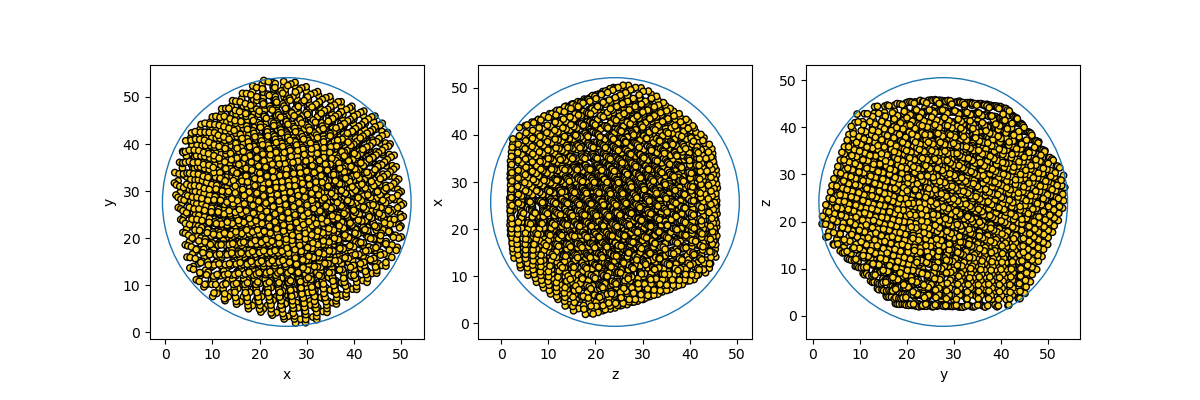

In [35]:
for obj in obj_list:
    display(obj)

### Surfactant measures

In [36]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SurfactantMoleculeMeasures'}
}

In [37]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [38]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

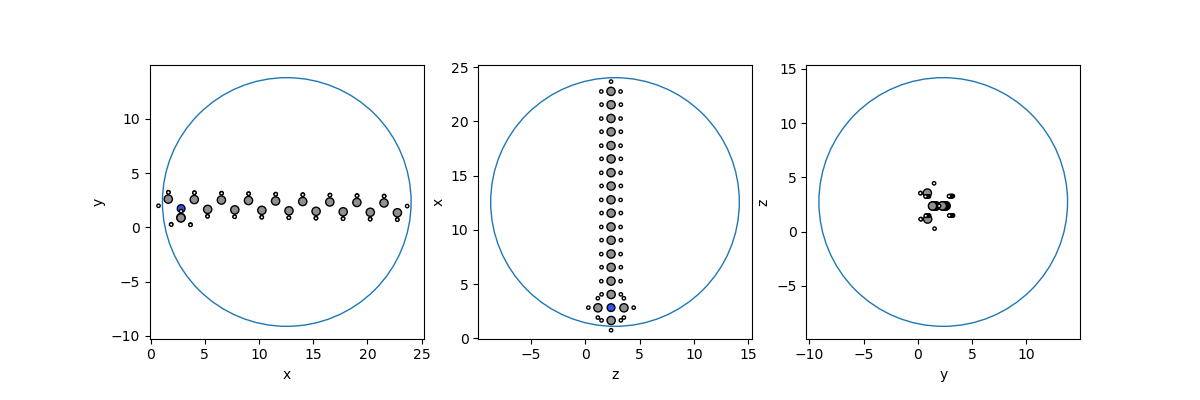

In [39]:
obj_list[0]

### Packing constraints

In [40]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'PackingConstraintSpheres'}
}

In [41]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [42]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

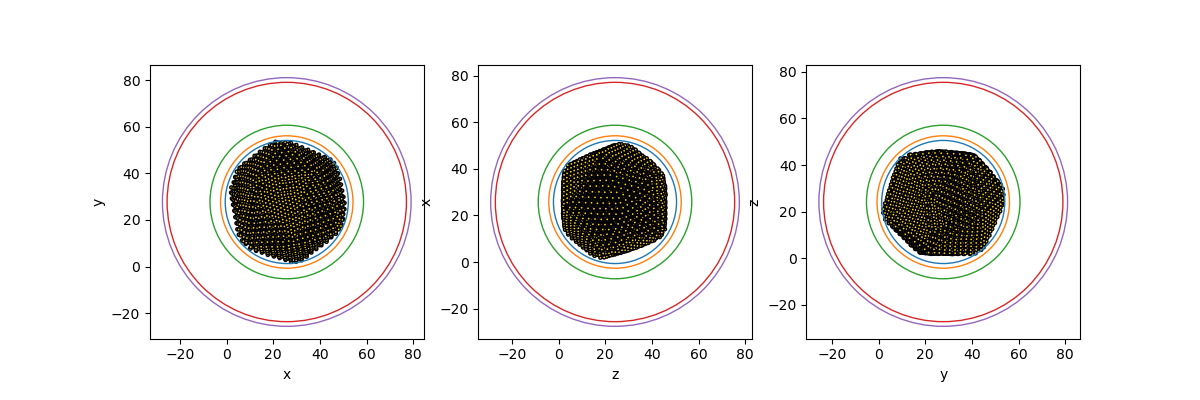

In [43]:
obj_list[0]

### Packed film

In [44]:
query = {
    'metadata.project': project_id,
    'metadata.type': 'png_file',
    'metadata.step': {'$regex': 'SphericalSurfactantPacking'}
}

In [45]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [46]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.png') as tmp:
        tmp.write(content)
        obj_list.append(Image(filename=tmp.name)) 
    print('.',end='')

.

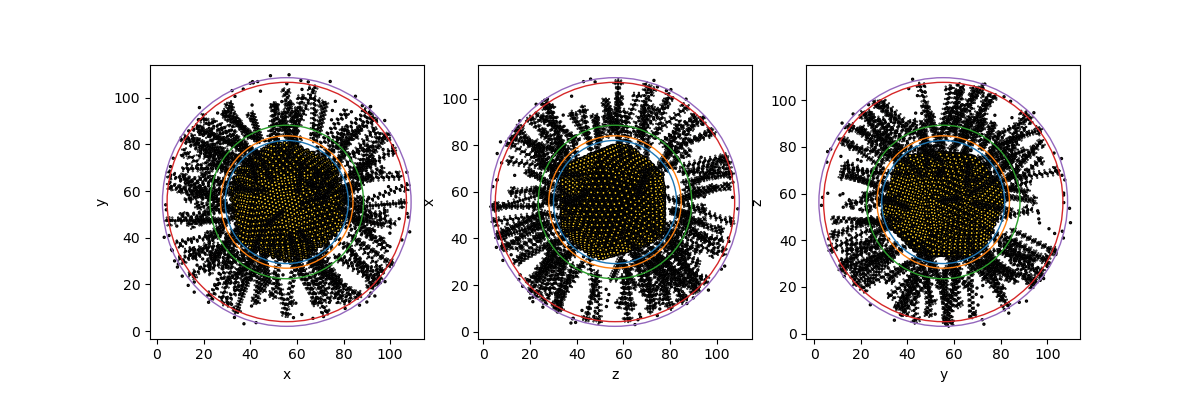

In [47]:
for obj in obj_list:
    display(obj)

## Energy minimization analysis

### Overview on objects in step

In [48]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad'
}

In [49]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

19

In [50]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [51]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-07-29 02:01:24.359171   
1                  surfactant_tail_rmsd   NaN  2020-07-29 02:01:24.359168   
2                  surfactant_head_rmsd   NaN  2020-07-29 02:01:24.359165   
3                        substrate_rmsd   NaN  2020-07-29 02:01:24.359163   
4                       counterion_rmsd   NaN  2020-07-29 02:01:24.359161   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.359158   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.359156   
7   surfactant_head_surfactant_head_rdf   NaN  2020-07-29 02:01:24.359154   
8         substrate_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.359151   
9         substrate_surfactant_head_rdf   NaN  2020-07-29 02:01:24.359149   
10              substrate_substrate_rdf   NaN  2020-07-29 02:01:24.359147   
11       counterion_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.359144   
12       counterion_surfactant_head_rdf   NaN  2020-07-29 02:01:24.359142   
13             counterion_substrate_rdf   NaN  2020-07-29 02:01:24.359140   
14            counterion_counterion_rdf   NaN  2020-07-29 02:01:24.359137   
15                            data_file   NaN  2020-07-29 02:01:24.359135   
16                      trajectory_file   NaN  2020-07-29 02:01:24.359132   
17                          energy_file   NaN  2020-07-29 02:01:24.359130   
18                             log_file   NaN  2020-07-29 02:01:24.359125   

                        latest  object_count  
0   2020-07-29 02:01:24.359171             1  
1   2020-07-29 02:01:24.359168             1  
2   2020-07-29 02:01:24.359165             1  
3   2020-07-29 02:01:24.359163             1  
4   2020-07-29 02:01:24.359161             1  
5   2020-07-29 02:01:24.359158             1  
6   2020-07-29 02:01:24.359156             1  
7   2020-07-29 02:01:24.359154             1  
8   2020-07-29 02:01:24.359151             1  
9   2020-07-29 02:01:24.359149             1  
10  2020-07-29 02:01:24.359147             1  
11  2020-07-29 02:01:24.359144             1  
12  2020-07-29 02:01:24.359142             1  
13  2020-07-29 02:01:24.359140             1  
14  2020-07-29 02:01:24.359137             1  
15  2020-07-29 02:01:24.359135             1  
16  2020-07-29 02:01:24.359132             1  
17  2020-07-29 02:01:24.359130             1  
18  2020-07-29 02:01:24.359125             1

### Global observables

In [52]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',  #{'$regex': 'GromacsEnergyMinimization'}
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

1

In [53]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [54]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [55]:
[ c for c in cursor]

[{'_id': {'nmolecules': 153},
  'degeneracy': 1,
  'latest': '5f20c1b17dc9cfbf44a4ba6f'}]

In [56]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

.


In [57]:
res_mi_df

Time         Bond          U-B  Proper Dih.  \
nmolecules step                                                      
153        0.0          0.0  4039.852539  5129.614258  5275.651367   
           1.0          1.0  4039.798340  5129.556152  5275.650879   
           2.0          2.0  4039.604980  5129.361816  5275.650391   
           3.0          3.0  4039.300537  5129.064941  5275.649902   
           4.0          4.0  4038.823486  5128.655762  5275.649414   
...                     ...          ...          ...          ...   
           9995.0    9995.0   288.360626  1875.738159  5593.802246   
           9997.0    9997.0   288.244720  1875.715576  5593.884766   
           9998.0    9998.0   288.457947  1875.773682  5593.809082   
           9999.0    9999.0   288.311035  1875.750732  5593.926270   
           10000.0  10000.0   288.668335  1875.865479  5593.808594   

                         LJ-14     Coulomb-14      LJ (SR)   Coulomb (SR)  \
nmolecules step                                                             
153        0.0      571.180603 -173127.671875 -548120.7500  134262.031250   
           1.0      571.179565 -173127.687500 -548362.0000  134260.671875   
           2.0      571.175354 -173127.687500 -548648.1250  134259.046875   
           3.0      571.168640 -173127.687500 -548986.1875  134257.093750   
           4.0      571.157715 -173127.671875 -549386.1875  134254.750000   
...                        ...            ...          ...            ...   
           9995.0  -490.423950 -169677.281250 -585210.4375  113856.054688   
           9997.0  -490.470337 -169677.156250 -585210.5000  113855.796875   
           9998.0  -490.408783 -169677.375000 -585210.4375  113855.664062   
           9999.0  -490.476868 -169677.187500 -585210.5625  113855.320312   
           10000.0 -490.389740 -169677.468750 -585210.5000  113855.289062   

                    Coul. recip.     Potential  ...  Pres-XY  Pres-XZ  \
nmolecules step                                 ...                     
153        0.0      53362.953125 -518607.15625  ...      0.0      0.0   
           1.0      53362.761719 -518850.06250  ...      0.0      0.0   
           2.0      53362.531250 -519138.46875  ...      0.0      0.0   
           3.0      53362.226562 -519479.37500  ...      0.0      0.0   
           4.0      53361.855469 -519883.00000  ...      0.0      0.0   
...                          ...           ...  ...      ...      ...   
           9995.0   10330.220703 -623433.93750  ...      0.0      0.0   
           9997.0   10330.056641 -623434.43750  ...      0.0      0.0   
           9998.0   10329.647461 -623434.87500  ...      0.0      0.0   
           9999.0   10329.462891 -623435.43750  ...      0.0      0.0   
           10000.0  10329.119141 -623435.56250  ...      0.0      0.0   

                    Pres-YX  Pres-YY  Pres-YZ  Pres-ZX  Pres-ZY  Pres-ZZ  \
nmolecules step                                                            
153        0.0          0.0      0.0      0.0      0.0      0.0      0.0   
           1.0          0.0      0.0      0.0      0.0      0.0      0.0   
           2.0          0.0      0.0      0.0      0.0      0.0      0.0   
           3.0          0.0      0.0      0.0      0.0      0.0      0.0   
           4.0          0.0      0.0      0.0      0.0      0.0      0.0   
...                     ...      ...      ...      ...      ...      ...   
           9995.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9997.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9998.0       0.0      0.0      0.0      0.0      0.0      0.0   
           9999.0       0.0      0.0      0.0      0.0      0.0      0.0   
           10000.0      0.0      0.0      0.0      0.0      0.0      0.0   

                    #Surf*SurfTen  T-rest  
nmolecules step                            
153        0.0                0.0     0.0  
           1.0                0.0     0

In [58]:
res_df

nmolecules     step     Time         Bond          U-B  Proper Dih.  \
0            153      0.0      0.0  4039.852539  5129.614258  5275.651367   
1            153      1.0      1.0  4039.798340  5129.556152  5275.650879   
2            153      2.0      2.0  4039.604980  5129.361816  5275.650391   
3            153      3.0      3.0  4039.300537  5129.064941  5275.649902   
4            153      4.0      4.0  4038.823486  5128.655762  5275.649414   
...          ...      ...      ...          ...          ...          ...   
7916         153   9995.0   9995.0   288.360626  1875.738159  5593.802246   
7917         153   9997.0   9997.0   288.244720  1875.715576  5593.884766   
7918         153   9998.0   9998.0   288.457947  1875.773682  5593.809082   
7919         153   9999.0   9999.0   288.311035  1875.750732  5593.926270   
7920         153  10000.0  10000.0   288.668335  1875.865479  5593.808594   

           LJ-14     Coulomb-14      LJ (SR)   Coulomb (SR)  ...  Pres-XY  \
0     571.180603 -173127.671875 -548120.7500  134262.031250  ...      0.0   
1     571.179565 -173127.687500 -548362.0000  134260.671875  ...      0.0   
2     571.175354 -173127.687500 -548648.1250  134259.046875  ...      0.0   
3     571.168640 -173127.687500 -548986.1875  134257.093750  ...      0.0   
4     571.157715 -173127.671875 -549386.1875  134254.750000  ...      0.0   
...          ...            ...          ...            ...  ...      ...   
7916 -490.423950 -169677.281250 -585210.4375  113856.054688  ...      0.0   
7917 -490.470337 -169677.156250 -585210.5000  113855.796875  ...      0.0   
7918 -490.408783 -169677.375000 -585210.4375  113855.664062  ...      0.0   
7919 -490.476868 -169677.187500 -585210.5625  113855.320312  ...      0.0   
7920 -490.389740 -169677.468750 -585210.5000  113855.289062  ...      0.0   

      Pres-XZ  Pres-YX  Pres-YY  Pres-YZ  Pres-ZX  Pres-ZY  Pres-ZZ  \
0         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
1         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
2         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
3         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
4         0.0      0.0      0.0      0.0      0.0      0.0      0.0   
...       ...      ...      ...      ...      ...      ...      ...   
7916      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7917      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7918      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7919      0.0      0.0      0.0      0.0      0.0      0.0      0.0   
7920      0.0      0.0      0.0      0.0      0.0      0.0      0.0   

      #Surf*SurfTen  T-rest  
0               0.0     0.0  
1               0.0     0.0  
2               0.0     0.0  
3               0.0     0.0  
4               0.0     0.0  
...             ...     ...  
7916            0.0     0.0  
7917            0.0     0.0  
7918            0.0     0.0  
7919            0.0     0.0  
7920            0.0     0.0  

[7921 rows x 33 columns]

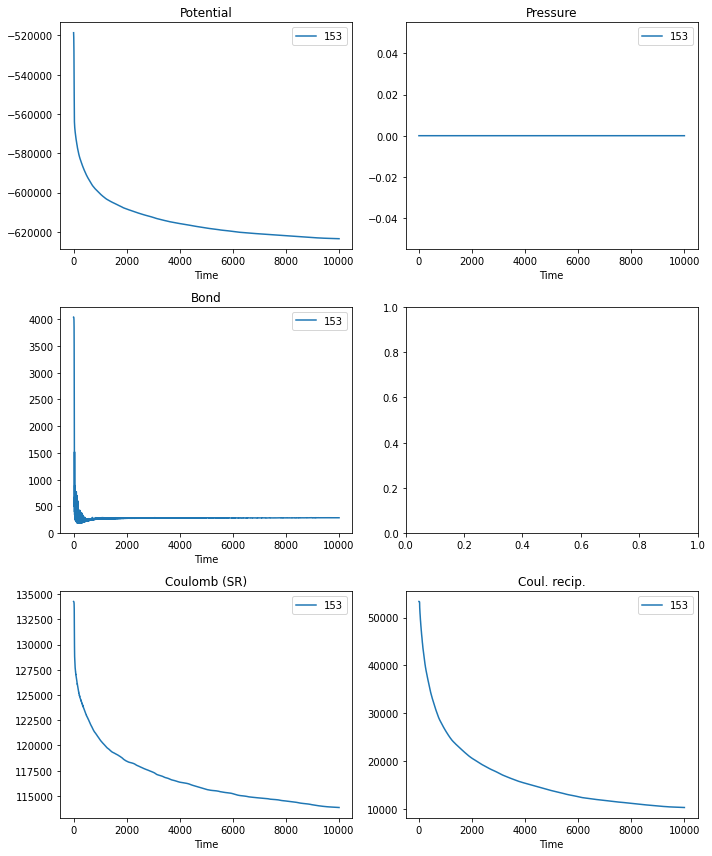

In [59]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [60]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimization:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [61]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [62]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [63]:
res_df

step      type  name  \
0  GromacsEnergyMinimization:ProcessAnalyzeAndVis...  mp4_file   NaN   

                     earliest                      latest  object_count  
0  2020-07-29 02:01:24.359171  2020-07-29 02:01:24.359171             1

In [64]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_list.append(Video.from_file(tmp.name))
    print('.',end='')

.

In [65]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

.

In [66]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10\xbe<mdat\x00\x…

## Pulling analysis

### Overview on objects in step

In [67]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad'
}

In [68]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

23

In [69]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [70]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-07-29 02:01:24.369486   
1                  surfactant_tail_rmsd   NaN  2020-07-29 02:01:24.369484   
2                  surfactant_head_rmsd   NaN  2020-07-29 02:01:24.369481   
3                        substrate_rmsd   NaN  2020-07-29 02:01:24.369479   
4                       counterion_rmsd   NaN  2020-07-29 02:01:24.369477   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.369474   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.369472   
7   surfactant_head_surfactant_head_rdf   NaN  2020-07-29 02:01:24.369469   
8         substrate_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.369467   
9         substrate_surfactant_head_rdf   NaN  2020-07-29 02:01:24.369465   
10              substrate_substrate_rdf   NaN  2020-07-29 02:01:24.369463   
11       counterion_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.369460   
12       counterion_surfactant_head_rdf   NaN  2020-07-29 02:01:24.369458   
13             counterion_substrate_rdf   NaN  2020-07-29 02:01:24.369456   
14            counterion_counterion_rdf   NaN  2020-07-29 02:01:24.369453   
15                        topology_file   NaN  2020-07-29 02:01:24.369451   
16                           pullx_file   NaN  2020-07-29 02:01:24.369449   
17                           pullf_file   NaN  2020-07-29 02:01:24.369447   
18                            data_file   NaN  2020-07-29 02:01:24.369444   
19           compressed_trajectory_file   NaN  2020-07-29 02:01:24.369442   
20                      trajectory_file   NaN  2020-07-29 02:01:24.369440   
21                          energy_file   NaN  2020-07-29 02:01:24.369437   
22                             log_file   NaN  2020-07-29 02:01:24.369432   

                        latest  object_count  
0   2020-07-29 02:01:24.369486             1  
1   2020-07-29 02:01:24.369484             1  
2   2020-07-29 02:01:24.369481             1  
3   2020-07-29 02:01:24.369479             1  
4   2020-07-29 02:01:24.369477             1  
5   2020-07-29 02:01:24.369474             1  
6   2020-07-29 02:01:24.369472             1  
7   2020-07-29 02:01:24.369469             1  
8   2020-07-29 02:01:24.369467             1  
9   2020-07-29 02:01:24.369465             1  
10  2020-07-29 02:01:24.369463             1  
11  2020-07-29 02:01:24.369460             1  
12  2020-07-29 02:01:24.369458             1  
13  2020-07-29 02:01:24.369456             1  
14  2020-07-29 02:01:24.369453             1  
15  2020-07-29 02:01:24.369451             1  
16  2020-07-29 02:01:24.369449             1  
17  2020-07-29 02:01:24.369447             1  
18  2020-07-29 02:01:24.369444             1  
19  2020-07-29 02:01:24.369442             1  
20  2020-07-29 02:01:24.369440             1  
21  2020-07-29 02:01:24.369437             1  
22  2020-07-29 02:01:24.369432             1

### Global observables

The `gmx energy` table:

```
  1  Restraint-Pot.   2  U-B              3  Proper-Dih.      4  LJ-14         
  5  Coulomb-14       6  LJ-(SR)          7  Coulomb-(SR)     8  Coul.-recip.  
  9  Position-Rest.  10  COM-Pull-En.    11  Potential       12  Kinetic-En.   
 13  Total-Energy    14  Temperature     15  Pressure        16  Constr.-rmsd  
 17  Vir-XX          18  Vir-XY          19  Vir-XZ          20  Vir-YX        
 21  Vir-YY          22  Vir-YZ          23  Vir-ZX          24  Vir-ZY        
 25  Vir-ZZ          26  Pres-XX         27  Pres-XY         28  Pres-XZ       
 29  Pres-YX         30  Pres-YY         31  Pres-YZ         32  Pres-ZX       
 33  Pres-ZY         34  Pres-ZZ         35  #Surf*SurfTen   36  T-rest       
 ```
 converted to dict with regex
 
     \s+([0-9]+)\s+([^\s]+)
 
 and replacement
 
     '$2': $1,\n

In [71]:
gmx_energy_dict = {
    'Restraint-Pot.': 1,
    'U-B': 2,
    'Proper-Dih.': 3,
    'LJ-14': 4,
    'Coulomb-14': 5,
    'LJ-(SR)': 6,
    'Coulomb-(SR)': 7,
    'Coul.-recip.': 8,
    'Position-Rest.': 9,
    'COM-Pull-En.': 10,
    'Potential': 11,
    'Kinetic-En.': 12,
    'Total-Energy': 13,
    'Temperature': 14,
    'Pressure': 15,
    'Constr.-rmsd': 16,
    'Vir-XX': 17,
    'Vir-XY': 18,
    'Vir-XZ': 19,
    'Vir-YX': 20,
    'Vir-YY': 21,
    'Vir-YZ': 22,
    'Vir-ZX': 23,
    'Vir-ZY': 24,
    'Vir-ZZ': 25,
    'Pres-XX': 26,
    'Pres-XY': 27,
    'Pres-XZ': 28,
    'Pres-YX': 29,
    'Pres-YY': 30,
    'Pres-YZ': 31,
    'Pres-ZX': 32,
    'Pres-ZY': 33,
    'Pres-ZZ': 34,
    '#Surf*SurfTen': 35,
    'T-rest': 36,
}

In [72]:
query = { 
    "metadata.project": project_id,
    "metadata.type":    'energy_file',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [73]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [74]:
gmx_energy_selection = [
    'Restraint-Pot.',
    'Position-Rest.',
    'COM-Pull-En.',
    'Potential',
    'Kinetic-En.',
    'Total-Energy',
    'Temperature',
    'Pressure',
    'Constr.-rmsd',
]

In [75]:
res_list = []
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

res_df_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    
    #df = panedr.edr_to_df(tmp.name), fails
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.edr', delete=False)
    
    # cur_res_dict = {}
    with tmpin:
        tmpin.write(content)
        #tmpin.seek(0)
       
    res_df = None
    for sel in gmx_energy_selection:  
        try:
            tmpout = tempfile.NamedTemporaryFile(suffix='.xvg', delete=False)
            res = gromacs.energy(f=tmpin.name,o=tmpout.name,
                                 input=str(gmx_energy_dict[sel]))
            #with open(tmpout.name,'r') as f:
            #    xvg = f.read()
            #tmpout.delete()
            xvg = mda.auxiliary.XVG.XVGReader(tmpout.name)
            xvg_time = xvg.read_all_times()
            xvg_data = np.array([ f.data[1:] for f in xvg ]).flatten() # 1st entry contains times
            os.unlink(tmpout.name)
        except: 
            logger.warning("Failed to read '{:s}' from data set {:d}.".format(sel,i))
            failed_list.append((nmolecules, sel))
        else:
            r = {'nmolecules': [nmolecules]*len(xvg_time), 'time': xvg_time, sel: xvg_data}
            cur_df = pd.DataFrame(r)
            if res_df is None:
                res_df = cur_df
            else:
                res_df = pd.merge(res_df, cur_df, how='outer', on=['nmolecules', 'time'])
    res_df_list.append(res_df)
    os.unlink(tmpin.name)
    print('.',end='')
print('')
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])

.


In [76]:
res_df_mi

Restraint-Pot.  Position-Rest.  COM-Pull-En.    Potential  \
nmolecules time                                                              
153        0.00       20.430475        0.000000      0.028977 -622885.9375   
           0.02        8.321078        0.000234      5.520246 -622965.5000   
           0.04        1.907546        0.003548     21.989100 -623004.5625   
           0.06        1.243387        0.019740     42.939671 -623021.1875   
           0.08        1.006776        0.074102     63.455784 -623020.1875   
...                         ...             ...           ...          ...   
           1.92       29.337511     1712.649170    166.974487 -625150.8750   
           1.94       27.349239     1731.973145    152.340683 -625186.1250   
           1.96       23.111673     1752.356445    140.675751 -625224.6250   
           1.98       21.202147     1773.864014    137.616669 -625235.3750   
           2.00       21.311953     1795.901123    139.113922 -625195.0625   

                 Kinetic-En.  Total-Energy  Temperature     Pressure  \
nmolecules time                                                        
153        0.00     9.771708  -622876.1875     0.120042  2051.541748   
           0.02    90.567245  -622874.9375     1.112582  2048.794434   
           0.04   140.420410  -622864.1250     1.725008  2053.360352   
           0.06   178.679565  -622842.5000     2.195007  2056.498779   
           0.08   202.259399  -622817.9375     2.484675  2061.586670   
...                      ...           ...          ...          ...   
           1.92  3339.685059  -621811.1875    41.026691  2161.054688   
           1.94  3385.539307  -621800.5625    41.589993  2162.669434   
           1.96  3434.236328  -621790.3750    42.188213  2166.269531   
           1.98  3453.848633  -621781.5000    42.429142  2169.000000   
           2.00  3422.916748  -621772.1250    42.049156  2166.428711   

                 Constr.-rmsd  
nmolecules time                
153        0.00      0.000003  
           0.02      0.000003  
           0.04      0.000003  
           0.06      0.000003  
           0.08      0.000003  
...                       ...  
           1.92      0.000003  
           1.94      0.000003  
           1.96      0.000003  
           1.98      0.000003  
           2.00      0.000003  

[101 rows x 9 columns]

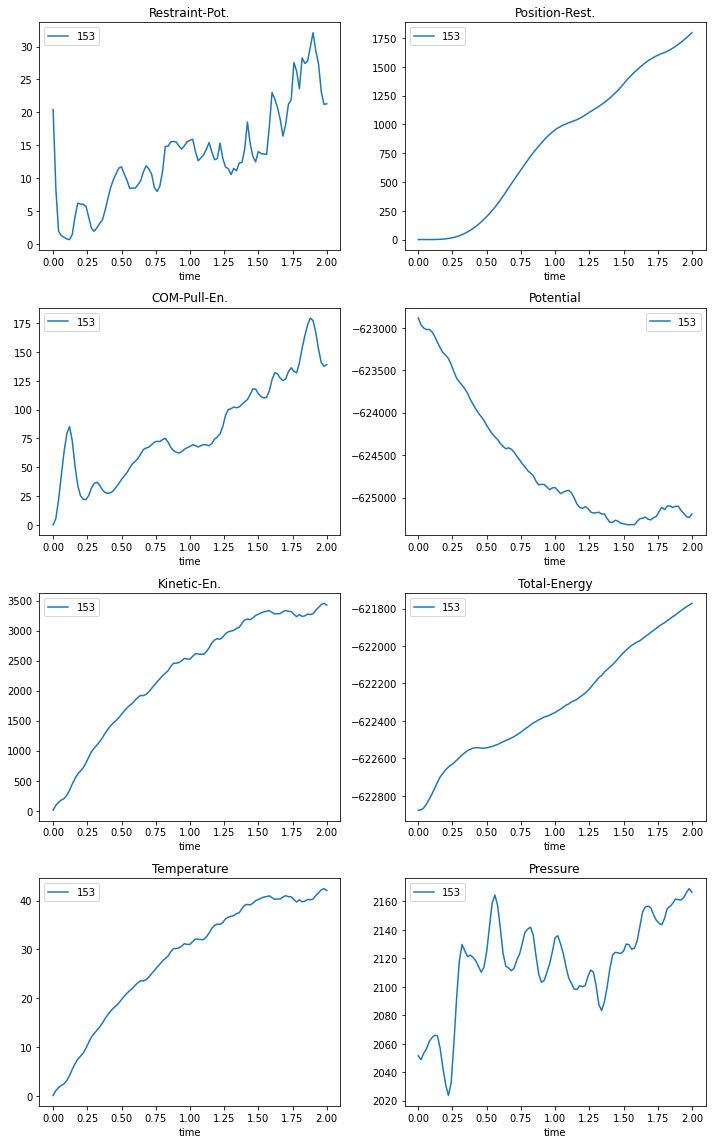

In [77]:
cols = 2
y_quantities = [
    'Restraint-Pot.',
    'Position-Rest.',
    'COM-Pull-En.',
    'Potential',
    'Kinetic-En.',
    'Total-Energy',
    'Temperature',
    'Pressure',
    'Constr.-rmsd',
    ]
n = len(y_quantities)
rows = round(n/cols)
positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Pulling forces

In [78]:
res_df_list = []
failed_list = []

query = { 
    "metadata.project": project_id,
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
    "metadata.type": 'pullf_file',
}

fp.filepad.count_documents(query)
match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.xvg', delete=False)
    
    with tmpin:
        tmpin.write(content)
        
    try:
        xvg = mda.auxiliary.XVG.XVGReader(tmpin.name)
        xvg_time = xvg.read_all_times()
        xvg_data = np.array([ f.data[1:] for f in xvg ])# .flatten() # 1st entry contains times
    except: 
        logger.warning("Failed to read data set {:d}.".format(i))
        failed_list.append(nmolecules)
    else:
        res_df_list.append(pd.DataFrame({
            'nmolecules': np.array([nmolecules]*len(xvg_time), dtype=int),
            'time': xvg_time, 
            **{i: xvg_data[:,i] for i in range(nmolecules)}
        }))
    os.unlink(tmpin.name)
    print('.',end='')
print('')
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])

.


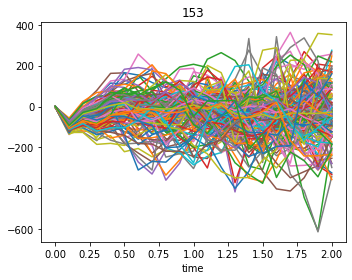

In [79]:
# pulling forces
n = len(res_df['nmolecules'].unique())
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
for pos, (key, grp) in zip(positions,res_df.groupby(['nmolecules'])):
    columns = list(set(grp.columns) - set(['nmolecules','time']))
    grp.plot('time', columns, ax=ax[pos],title=key,legend=None)
fig.tight_layout()

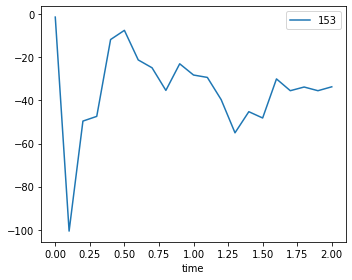

In [80]:
# mean pulling force
fig, ax = plt.subplots(1,1,figsize=(5,4))
for key, grp in res_df.groupby(['nmolecules']):
    columns = list(set(grp.columns) - set(['nmolecules','time']))
    grp = grp.set_index('time')
    grp = grp.drop(columns='nmolecules')
    grp.mean(axis=1).plot(legend=True, label=key, ax=ax)
fig.tight_layout()
#fig.legend()

### Pulling groups movement

In [81]:
res_df_list = []
failed_list = []

query = { 
    "metadata.project": project_id,
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
    "metadata.type":    'pullx_file',
}

fp.filepad.count_documents(query)
match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)


for i, c in enumerate(cursor): 
    print(c["_id"])
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])  # int(metadata["metadata"]["nmolecules"])
    
    tmpin = tempfile.NamedTemporaryFile(mode='w+b',suffix='.xvg', delete=False)
    
    with tmpin:
        tmpin.write(content)
        
    try:
        xvg = gromacs.fileformats.XVG(tmpin.name)
        xvg_time = xvg.array[0,:]
        
        #xvg_labels = ['1', '1 ref', '1 dX', '1 dY', '1 dZ', '1 g 1 X', '1 g 1 Y', '1 g 1 Z', '1 g 2 X', '1 g 2 Y', '1 g 2 Z']
        N_pull_coords = nmolecules
        N_cols = len(xvg.names)
        N_cols_per_coord = int(N_cols / N_pull_coords)
        
        xvg_labels = xvg.names[:N_cols_per_coord]
        xvg_data = {}
        for j in range(N_pull_coords):
            for k in range(N_cols_per_coord):
                xvg_data[(j,xvg_labels[k])] = xvg.array[
                    1+j*N_cols_per_coord+k,:]
        
    except: 
        logger.exception("Failed to read data set {:d}.".format(i))
        failed_list.append(nmolecules)

    else:
        res_df_list.append(pd.DataFrame({
            'nmolecules': np.array([nmolecules]*len(xvg_time), dtype=int),
            'time': xvg_time, 
            **xvg_data # {i: xvg_data[:,i] for i in range(nmolecules)}
        }))
    os.unlink(tmpin.name)
res_df = pd.concat(res_df_list)
res_df_mi = res_df.set_index(['nmolecules','time'])
res_df_mi.columns = pd.MultiIndex.from_tuples(res_df_mi.columns, names=['nmolecule', 'coord'])

{'nmolecules': 153}


In [82]:
res_df_mi

nmolecule            0                                                        \
coord                  1   1 ref      1 dX     1 dY     1 dZ 1 g 1 X 1 g 1 Y   
nmolecules time                                                                
153        0.0   3.25537  3.2552  0.682214 -2.88902 -1.33626   7.679   7.534   
           0.2   3.23373  3.2352  0.689981 -2.85243 -1.35815   7.679   7.534   
           0.4   3.20370  3.2152  0.690009 -2.79476 -1.40600   7.679   7.534   
           0.6   3.18147  3.1952  0.733030 -2.78056 -1.36122   7.679   7.534   
           0.8   3.17838  3.1752  0.768814 -2.79597 -1.30137   7.679   7.534   
           1.0   3.16378  3.1552  0.746302 -2.80080 -1.26810   7.679   7.534   
           1.2   3.14226  3.1352  0.736834 -2.80370 -1.21251   7.679   7.534   
           1.4   3.10894  3.1152  0.656814 -2.80054 -1.17946   7.679   7.534   
           1.6   3.08767  3.0952  0.563070 -2.79213 -1.19191   7.679   7.534   
           1.8   3.07772  3.0752  0.526463 -2.78358 -1.20286   7.679   7.534   
           2.0   3.05998  3.0552  0.538155 -2.75691 -1.21381   7.679   7.534   

nmolecule                                  ...      152                    \
coord           1 g 1 Z  1 g 2 X  1 g 2 Y  ...    1 ref     1 dX     1 dY   
nmolecules time                            ...                              
153        0.0    7.481  8.36122  4.64498  ...  3.18389  2.98797  1.04594   
           0.2    7.481  8.36899  4.68157  ...  3.16389  2.96629  1.05281   
           0.4    7.481  8.36901  4.73923  ...  3.14389  2.93092  1.06517   
           0.6    7.481  8.41203  4.75344  ...  3.12389  2.90359  1.08038   
           0.8    7.481  8.44782  4.73803  ...  3.10389  2.86673  1.09524   
           1.0    7.481  8.42531  4.73320  ...  3.08389  2.86431  1.09108   
           1.2    7.481  8.41584  4.73030  ...  3.06389  2.83332  1.08370   
           1.4    7.481  8.33582  4.73346  ...  3.04389  2.81751  1.12964   
           1.6    7.481  8.24207  4.74186  ...  3.02389  2.79287  1.15060   
           1.8    7.481  8.20547  4.75041  ...  3.00389  2.72557  1.21527   
           2.0    7.481  8.21716  4.77709  ...  2.98389  2.73025  1.17085   

nmolecule                                                                     
coord                1 dZ 1 g 1 X 1 g 1 Y 1 g 1 Z  1 g 2 X  1 g 2 Y  1 g 2 Z  
nmolecules time                                                               
153        0.0   0.339039   7.679   7.534   7.481  10.6670  8.57994  7.82004  
           0.2   0.347905   7.679   7.534   7.481  10.6453  8.58681  7.82891  
           0.4   0.359447   7.679   7.534   7.481  10.6099  8.59917  7.84045  
           0.6   0.353973   7.679   7.534   7.481  10.5826  8.61438  7.83497  
           0.8   0.376253   7.679   7.534   7.481  10.5457  8.62924  7.85725  
           1.0   0.381071   7.679   7.534   7.481  10.5433  8.62507  7.86207  
           1.2   0.409817   7.679   7.534   7.481  10.5123  8.61770  7.89082  
           1.4   0.421809   7.679   7.534   7.481  10.4965  8.66363  7.90281  
           1.6   0.480551   7.679   7.534   7.481  10.4719  8.68459  7.96155  
           1.8   0.526737   7.679   7.534   7.481  10.4046  8.74927  8.00774  
           2.0   0.450463   7.679   7.534   7.481  10.4092  8.70484  7.93146  

[11 rows x 1683 columns]

In [83]:
res_df = res_df_mi.groupby(axis=1,level='coord').mean().reset_index()

In [84]:
res_df

coord  nmolecules  time         1      1 dX      1 dY      1 dZ  1 g 1 X  \
0             153   0.0  3.237850 -0.143298 -0.002007  0.055597    7.679   
1             153   0.2  3.222671 -0.144344 -0.002955  0.055311    7.679   
2             153   0.4  3.198890 -0.146817 -0.004678  0.054613    7.679   
3             153   0.6  3.179835 -0.148481 -0.004889  0.055305    7.679   
4             153   0.8  3.161249 -0.149584 -0.004795  0.056728    7.679   
5             153   1.0  3.140536 -0.151879 -0.006793  0.056095    7.679   
6             153   1.2  3.121677 -0.151836 -0.008013  0.057090    7.679   
7             153   1.4  3.102236 -0.153550 -0.008808  0.060656    7.679   
8             153   1.6  3.080716 -0.155596 -0.010737  0.059457    7.679   
9             153   1.8  3.061092 -0.159862 -0.009818  0.057241    7.679   
10            153   2.0  3.041081 -0.160376 -0.007706  0.061528    7.679   

coord  1 g 1 Y  1 g 1 Z   1 g 2 X   1 g 2 Y   1 g 2 Z     1 ref  
0        7.534    7.481  7.535705  7.531990  7.536599  3.237714  
1        7.534    7.481  7.534661  7.531042  7.536312  3.217714  
2        7.534    7.481  7.532187  7.529318  7.535613  3.197714  
3        7.534    7.481  7.530524  7.529108  7.536306  3.177714  
4        7.534    7.481  7.529420  7.529201  7.537730  3.157714  
5        7.534    7.481  7.527125  7.527203  7.537095  3.137714  
6        7.534    7.481  7.527168  7.525984  7.538091  3.117714  
7        7.534    7.481  7.525454  7.525188  7.541658  3.097714  
8        7.534    7.481  7.523408  7.523258  7.540459  3.077714  
9        7.534    7.481  7.519143  7.524179  7.538241  3.057714  
10       7.534    7.481  7.518627  7.526292  7.542528  3.037714

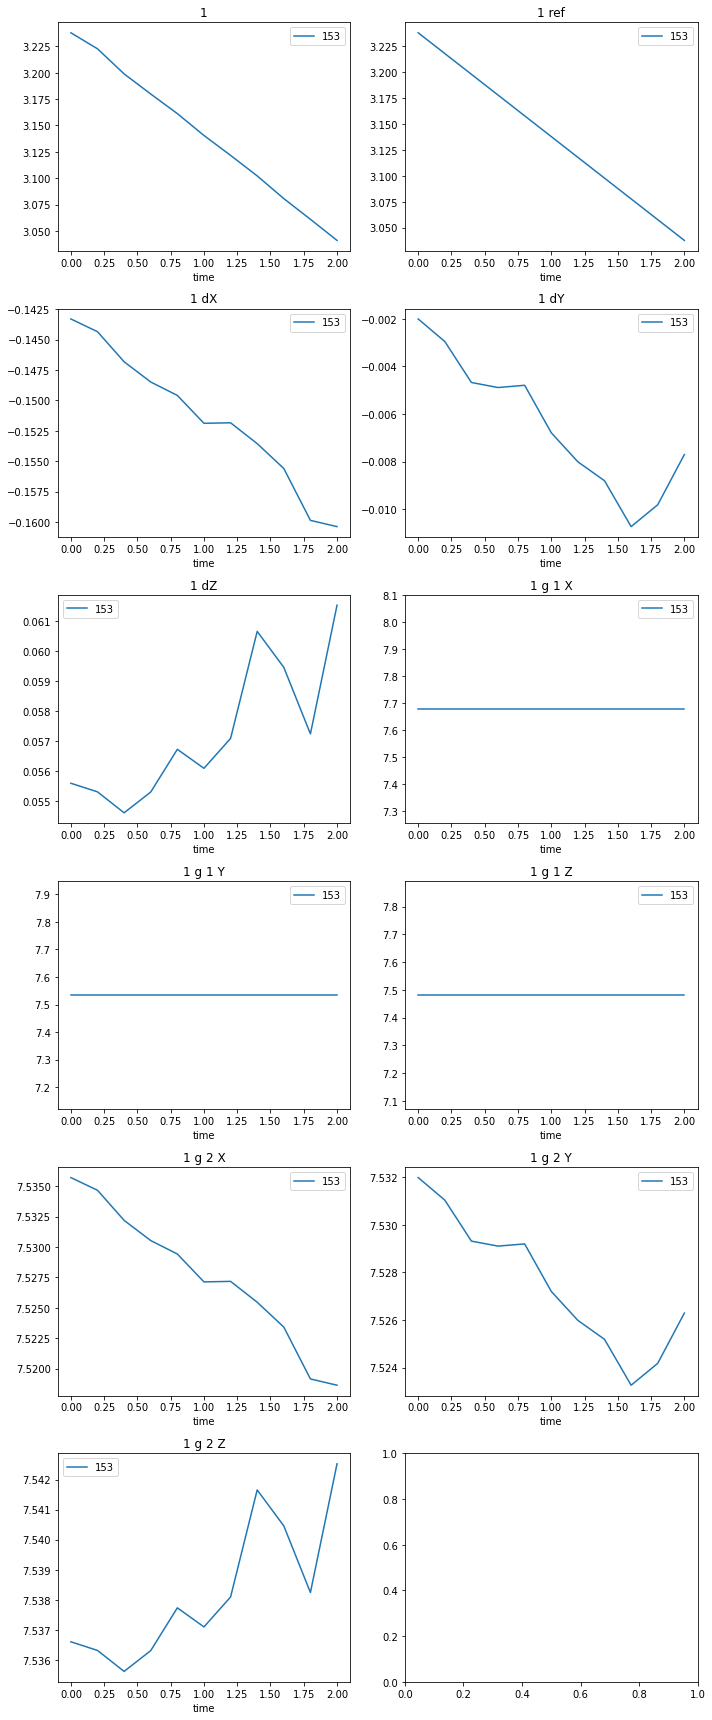

In [85]:
cols = 2
y_quantities = [
    '1', 
    '1 ref', 
    '1 dX', 
    '1 dY', 
    '1 dZ', 
    '1 g 1 X', 
    '1 g 1 Y', 
    '1 g 1 Z', 
    '1 g 2 X', 
    '1 g 2 Y', 
    '1 g 2 Z'
]
n = len(y_quantities)
rows = round(n/cols)
positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [86]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsPull:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [87]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [88]:
# check files degenerate by 'metadata.type' ad 'metadata.name'

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
                'step': '$metadata.step',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['step', 'type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [89]:
res_df

step      type  name  \
0  GromacsPull:ProcessAnalyzeAndVisualize:push_fi...  mp4_file   NaN   

                     earliest                      latest  object_count  
0  2020-07-29 02:01:24.369486  2020-07-29 02:01:24.369486             1

In [90]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["gfs_id"])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_list.append(Video.from_file(tmp.name))
    print('.',end='')

.

In [91]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x10\xbe<mdat\x00\x…


### Pre-evaluated RDF

#### Overview

In [92]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

10

In [93]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [94]:
res_df

type                    earliest  \
0  surfactant_tail_surfactant_tail_rdf  2020-07-29 02:01:24.369474   
1  surfactant_head_surfactant_tail_rdf  2020-07-29 02:01:24.369472   
2  surfactant_head_surfactant_head_rdf  2020-07-29 02:01:24.369469   
3        substrate_surfactant_tail_rdf  2020-07-29 02:01:24.369467   
4        substrate_surfactant_head_rdf  2020-07-29 02:01:24.369465   
5              substrate_substrate_rdf  2020-07-29 02:01:24.369463   
6       counterion_surfactant_tail_rdf  2020-07-29 02:01:24.369460   
7       counterion_surfactant_head_rdf  2020-07-29 02:01:24.369458   
8             counterion_substrate_rdf  2020-07-29 02:01:24.369456   
9            counterion_counterion_rdf  2020-07-29 02:01:24.369453   

                       latest  object_count  
0  2020-07-29 02:01:24.369474             1  
1  2020-07-29 02:01:24.369472             1  
2  2020-07-29 02:01:24.369469             1  
3  2020-07-29 02:01:24.369467             1  
4  2020-07-29 02:01:24.369465             1  
5  2020-07-29 02:01:24.369463             1  
6  2020-07-29 02:01:24.369460             1  
7  2020-07-29 02:01:24.369458             1  
8  2020-07-29 02:01:24.369456             1  
9  2020-07-29 02:01:24.369453             1

#### Substrate - surfactant head RDF

In [95]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [96]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [97]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


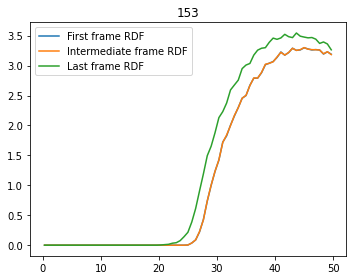

In [98]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Substrate - surfactant tail RDF

In [99]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [100]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [101]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


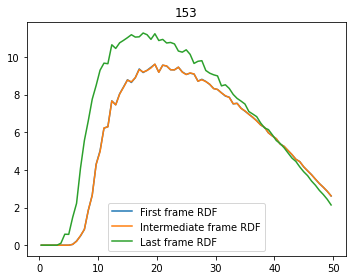

In [102]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

#### Surfactant head - surfactant tail RDF

In [103]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [104]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": "GromacsPull:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

1

In [105]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

.


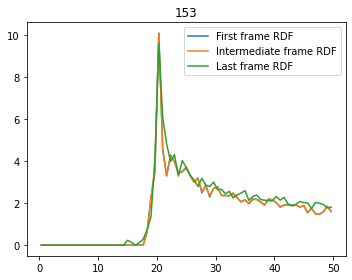

In [106]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

## Energy minimization after solvation analysis

### Overview on objects in step

In [107]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad'
}

In [108]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

20

In [109]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [110]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-07-29 02:01:24.379766   
1                  surfactant_tail_rmsd   NaN  2020-07-29 02:01:24.379763   
2                  surfactant_head_rmsd   NaN  2020-07-29 02:01:24.379761   
3                        substrate_rmsd   NaN  2020-07-29 02:01:24.379758   
4                       counterion_rmsd   NaN  2020-07-29 02:01:24.379756   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.379754   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.379751   
7   surfactant_head_surfactant_head_rdf   NaN  2020-07-29 02:01:24.379749   
8         substrate_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.379747   
9         substrate_surfactant_head_rdf   NaN  2020-07-29 02:01:24.379745   
10              substrate_substrate_rdf   NaN  2020-07-29 02:01:24.379742   
11       counterion_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.379740   
12       counterion_surfactant_head_rdf   NaN  2020-07-29 02:01:24.379738   
13             counterion_substrate_rdf   NaN  2020-07-29 02:01:24.379735   
14            counterion_counterion_rdf   NaN  2020-07-29 02:01:24.379733   
15                        topology_file   NaN  2020-07-29 02:01:24.379731   
16                            data_file   NaN  2020-07-29 02:01:24.379728   
17                      trajectory_file   NaN  2020-07-29 02:01:24.379726   
18                          energy_file   NaN  2020-07-29 02:01:24.379723   
19                             log_file   NaN  2020-07-29 02:01:24.379718   

                        latest  object_count  
0   2020-07-29 02:01:24.379766             1  
1   2020-07-29 02:01:24.379763             1  
2   2020-07-29 02:01:24.379761             1  
3   2020-07-29 02:01:24.379758             1  
4   2020-07-29 02:01:24.379756             1  
5   2020-07-29 02:01:24.379754             1  
6   2020-07-29 02:01:24.379751             1  
7   2020-07-29 02:01:24.379749             1  
8   2020-07-29 02:01:24.379747             1  
9   2020-07-29 02:01:24.379745             1  
10  2020-07-29 02:01:24.379742             1  
11  2020-07-29 02:01:24.379740             1  
12  2020-07-29 02:01:24.379738             1  
13  2020-07-29 02:01:24.379735             1  
14  2020-07-29 02:01:24.379733             1  
15  2020-07-29 02:01:24.379731             1  
16  2020-07-29 02:01:24.379728             1  
17  2020-07-29 02:01:24.379726             1  
18  2020-07-29 02:01:24.379723             1  
19  2020-07-29 02:01:24.379718             1

### Global observables

In [111]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',  #{'$regex': 'GromacsEnergyMinimization'}
    "metadata.type": 'energy_file',
}
fp.filepad.count_documents(query)

1

In [112]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [113]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [114]:
res_mi_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        em_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),em_df.index],
            names=[*c["_id"].keys(),'step'])
        em_mi_df = em_df.set_index(mi)        
        res_mi_list.append(em_mi_df)
    print('.',end='')
print('')

res_mi_df = pd.concat(res_mi_list)
res_df = res_mi_df.reset_index()

.


In [115]:
res_mi_df

Time        Bond          U-B  Proper Dih.       LJ-14  \
nmolecules step                                                                 
153        0.0          0.0   39.896023  2543.439697  6211.174805 -350.725067   
           1.0          1.0   39.893581  2543.505859  6211.181152 -350.721313   
           2.0          2.0   39.889889  2543.586426  6211.188477 -350.717255   
           3.0          3.0   39.886368  2543.688232  6211.197754 -350.712616   
           4.0          4.0   39.882565  2543.809570  6211.207031 -350.706696   
...                     ...         ...          ...          ...         ...   
           9995.0    9995.0  136.121506  1832.380493  5904.397461 -456.112793   
           9996.0    9996.0  137.988342  1834.825195  5904.607910 -456.163055   
           9997.0    9997.0  139.497192  1833.807739  5904.394043 -456.087219   
           9999.0    9999.0  133.246078  1831.666992  5904.450684 -456.155090   
           10000.0  10000.0  142.276459  1835.047119  5904.393555 -456.071777   

                       Coulomb-14        LJ (SR)  Coulomb (SR)  Coul. recip.  \
nmolecules step                                                                
153        0.0     -169461.500000  471354.781250    -4777757.0  29306.673828   
           1.0     -169461.531250  470730.156250    -4777761.0  29306.546875   
           2.0     -169461.578125  469983.187500    -4777765.0  29306.373047   
           3.0     -169461.625000  469087.562500    -4777770.5  29306.240234   
           4.0     -169461.671875  468015.906250    -4777777.0  29306.076172   
...                           ...            ...           ...           ...   
           9995.0  -169921.359375   40990.089844    -5755417.0   6923.923828   
           9996.0  -169922.203125   40993.589844    -5755425.0   6923.675293   
           9997.0  -169921.187500   40997.257812    -5755431.0   6923.885254   
           9999.0  -169921.796875   40999.054688    -5755435.0   6923.694336   
           10000.0 -169920.984375   41018.050781    -5755473.5   6923.671875   

                    Position Rest.  ...   Pres-XY    Pres-XZ   Pres-YX  \
nmolecules step                     ...                                  
153        0.0            0.126243  ... -5.033666  15.401787 -5.033669   
           1.0            0.126273  ... -5.033163  15.402425 -5.033164   
           2.0            0.126378  ... -5.032430  15.403424 -5.032430   
           3.0            0.126602  ... -5.031769  15.404584 -5.031770   
           4.0            0.127029  ... -5.030987  15.405773 -5.030984   
...                            ...  ...       ...        ...       ...   
           9995.0      1202.316528  ... -7.876544  11.686769 -7.876546   
           9996.0      1202.307861  ... -7.876268  11.686562 -7.876265   
           9997.0      1202.338623  ... -7.876096  11.686405 -7.876094   
           9999.0      1202.314575  ... -7.875922  11.686318 -7.875923   
           10000.0     1202.377686  ... -7.874590  11.685333 -7.874591   

                       Pres-YY   Pres-YZ    Pres-ZX   Pres-ZY     Pres-ZZ  \
nmolecules step                                                             
153        0.0     -307.340942 -3.832606  15.401790 -3.832607 -319.082703   
           1.0     -307.340851 -3.833294  15.402428 -3.833296 -319.083374   
           2.0     -307.341095 -3.834089  15.403425 -3.834090 -319.084167   
           3.0     -307.341339 -3.835160  15.404587 -3.835159 -319.085236   
           4.0     -307.341644 -3.836285  15.405770 -3.836287 -319.086609   
...                        ...       ...        ...       ...         ...   
           9995.0  -365.811188  1.176714  11.686770  1.176714 -379.987183   
           9996.0  -365.811646  1.176887  11.686564  1.176887 -379.988037   
           9997.0  -365.812012  1.177065  11.686400  1.177063 -379.988647   
           9999.0  -365.812195  1.177207  11.686323  1.177206 -379.989044   
           10000.0 -365.814728  1.178119 

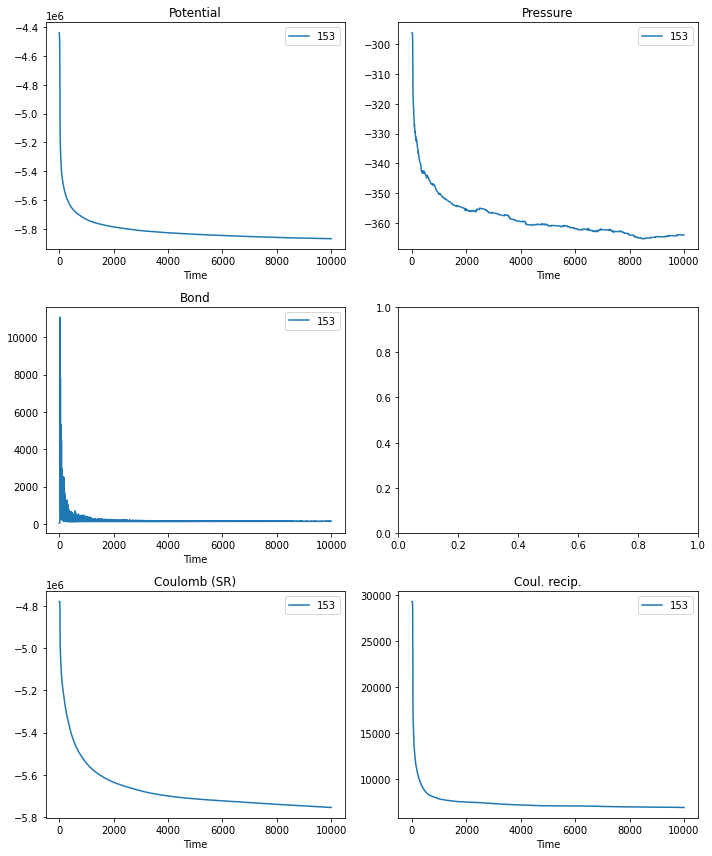

In [116]:
y_quantities = [
    'Potential',
    'Pressure',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

positions = [
    (0,0),
    (0,1),
    (1,0),
    (2,0),
    (2,1),
]
fig, ax = plt.subplots(3,2,figsize=(10,12))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

###  Visualize trajectory

In [117]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsEnergyMinimizationAfterSolvation:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [118]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [119]:
# check

aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'nmolecules': '$metadata.system.surfactant.nmolecules'
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

# for i, c in enumerate(cursor): 
#    content, metadata = fp.get_file_by_id(c["latest"])
#    nmolecules = int(c["_id"]["nmolecules"])
    

res = [ {**c['_id'], **c} for c in cursor]
columns = ['nmolecules', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [120]:
res_df

nmolecules  name                    earliest                      latest  \
0         153   NaN  2020-07-29 02:01:24.379766  2020-07-29 02:01:24.379766   

   object_count  
0             1

In [121]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        obj_dict.update({metadata['metadata']['system']['surfactant']['nmolecules']: Video.from_file(tmp.name)})
    print('.',end='')

.

In [122]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

153


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x07\x1b\xd0mdat\x0…

## NVT equilibration analysis

### Overview on objects in step

In [321]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [322]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

21

In [323]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [324]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-07-29 02:01:24.390214   
1                  surfactant_tail_rmsd   NaN  2020-07-29 02:01:24.390212   
2                  surfactant_head_rmsd   NaN  2020-07-29 02:01:24.390210   
3                        substrate_rmsd   NaN  2020-07-29 02:01:24.390207   
4                       counterion_rmsd   NaN  2020-07-29 02:01:24.390205   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.390203   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.390200   
7   surfactant_head_surfactant_head_rdf   NaN  2020-07-29 02:01:24.390198   
8         substrate_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.390196   
9         substrate_surfactant_head_rdf   NaN  2020-07-29 02:01:24.390194   
10              substrate_substrate_rdf   NaN  2020-07-29 02:01:24.390191   
11       counterion_surfactant_tail_rdf   NaN  2020-07-29 02:01:24.390189   
12       counterion_surfactant_head_rdf   NaN  2020-07-29 02:01:24.390187   
13             counterion_substrate_rdf   NaN  2020-07-29 02:01:24.390184   
14            counterion_counterion_rdf   NaN  2020-07-29 02:01:24.390182   
15                           index_file   NaN  2020-07-29 02:01:24.390180   
16                        topology_file   NaN  2020-07-29 02:01:24.390177   
17                            data_file   NaN  2020-07-29 02:01:24.390175   
18                      trajectory_file   NaN  2020-07-29 02:01:24.390173   
19                          energy_file   NaN  2020-07-29 02:01:24.390170   
20                             log_file   NaN  2020-07-29 02:01:24.390165   

                        latest  object_count  
0   2020-07-29 02:01:24.390214             1  
1   2020-07-29 02:01:24.390212             1  
2   2020-07-29 02:01:24.390210             1  
3   2020-07-29 02:01:24.390207             1  
4   2020-07-29 02:01:24.390205             1  
5   2020-07-29 02:01:24.390203             1  
6   2020-07-29 02:01:24.390200             1  
7   2020-07-29 02:01:24.390198             1  
8   2020-07-29 02:01:24.390196             1  
9   2020-07-29 02:01:24.390194             1  
10  2020-07-29 02:01:24.390191             1  
11  2020-07-29 02:01:24.390189             1  
12  2020-07-29 02:01:24.390187             1  
13  2020-07-29 02:01:24.390184             1  
14  2020-07-29 02:01:24.390182             1  
15  2020-07-29 02:01:24.390180             1  
16  2020-07-29 02:01:24.390177             1  
17  2020-07-29 02:01:24.390175             1  
18  2020-07-29 02:01:24.390173             1  
19  2020-07-29 02:01:24.390170             1  
20  2020-07-29 02:01:24.390165             1

### Global observables

In [325]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

1

In [326]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [327]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [328]:
[ c for c in cursor]

[{'_id': {'nmolecules': 153},
  'degeneracy': 1,
  'latest': '5f20d0627dc9cfbf44a4dda3'}]

In [329]:
res_list = []

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

.


In [330]:
res_df.columns

Index(['nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-14:Surfactant-Ion',
       'Coul-SR:Surfactant-rest', 'LJ-SR:Surfactant-rest',
       'Coul-14:Surfactant-rest', 'LJ-14:Sur

In [331]:
res_df_mi

Time         Bond           U-B  Proper Dih.       LJ-14  \
nmolecules step                                                               
153        0.0      0.0   191.521286   1911.195557  5906.845703 -455.684540   
           1.0      1.0  2206.802734  14809.690430  7913.095215  -26.561762   
           2.0      2.0  2529.195068  17595.285156  8338.059570   17.914547   
           3.0      3.0  2785.072021  19373.660156  8617.284180   99.151787   
           4.0      4.0  2941.251709  20440.796875  8637.584961  122.368546   
...                 ...          ...           ...          ...         ...   
           96.0    96.0  2885.923340  20146.361328  8857.896484  160.181976   
           97.0    97.0  2830.005859  20171.742188  8647.293945  138.834381   
           98.0    98.0  2944.382080  19753.224609  8725.625977  160.386169   
           99.0    99.0  2792.977051  20043.318359  8828.899414  165.594864   
           100.0  100.0  2759.780762  20196.830078  8878.982422  145.354507   

                     Coulomb-14        LJ (SR)  Coulomb (SR)  Coul. recip.  \
nmolecules step                                                              
153        0.0   -169926.609375   41307.890625    -5755735.5   6947.271973   
           1.0   -170020.703125  -27579.964844    -5131930.0  10703.608398   
           2.0   -169963.250000  -55675.066406    -4984613.5   7947.065918   
           3.0   -169849.015625  -76212.312500    -4874269.5   8645.708984   
           4.0   -169953.859375 -100456.406250    -4780876.0   9058.947266   
...                         ...            ...           ...           ...   
           96.0  -170065.468750 -157732.359375    -4535832.5  10486.708008   
           97.0  -169857.421875 -152751.078125    -4539774.0  10300.739258   
           98.0  -169886.687500 -156372.890625    -4536419.0  10397.327148   
           99.0  -170168.000000 -156070.906250    -4538602.5  10394.189453   
           100.0 -170190.609375 -155354.312500    -4540474.5  10585.566406   

                  Position Rest.  ...  Coul-14:Ion-rest  LJ-14:Ion-rest  \
nmolecules step                   ...                                     
153        0.0          0.003225  ...               0.0             0.0   
           1.0       1741.344482  ...               0.0             0.0   
           2.0       1892.831909  ...               0.0             0.0   
           3.0       2198.970215  ...               0.0             0.0   
           4.0       2224.557373  ...               0.0             0.0   
...                          ...  ...               ...             ...   
           96.0      2526.470703  ...               0.0             0.0   
           97.0      2376.564697  ...               0.0             0.0   
           98.0      2540.685303  ...               0.0             0.0   
           99.0      2394.165771  ...               0.0             0.0   
           100.0     2422.623779  ...               0.0             0.0   

                  Coul-SR:rest-rest  LJ-SR:rest-rest  Coul-14:rest-rest  \
nmolecules step                                                           
153        0.0           -5838397.5     656948.18750                0.0   
           1.0           -5213977.0     588043.87500                0.0   
           2.0           -5064840.0     560325.87500                0.0   
           3.0           -4953858.0     540177.18750                0.0   
           4.0           -4860241.5     516081.37500                0.0   
...                             ...              ...                ...   
           96.0          -4615819.5     458104.46875                0.0   
           97.0          -4619239.5     462607.15625                0.0   
           98.0          -4616187.0     459240.93750                0.0   
           99.0          -4619111.0     459590.31250                0.0   
           100.0         -4620772.0     460341.21875                0.0   

                  LJ-14:

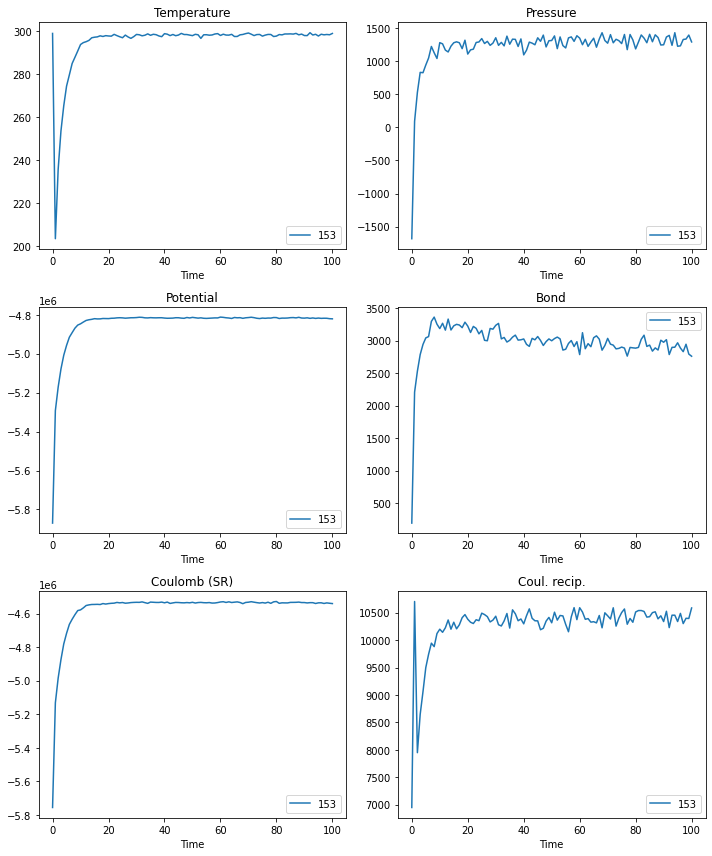

In [332]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [333]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNVTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [334]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

1

In [335]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

.

In [336]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x00\x1d\xc7qmdat\x00\x…

## NPT equilibration analysis

### Datasets in step

In [337]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [338]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'dataset': '$metadata.step_specific.dtool_push.remote_dataset',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id']['dataset'], **c} for c in cursor]
columns = ['uuid', 'name', 'uri', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [339]:
res_df

Empty DataFrame
Columns: [uuid, name, uri, earliest, latest, object_count]
Index: []

### Overview on objects in step

In [340]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad'
}

In [341]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

0

In [342]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [343]:
res_df

Empty DataFrame
Columns: [type, name, earliest, latest, object_count]
Index: []

### Global observables

In [344]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

0

In [345]:
metadata = fp.filepad.find_one(query)

In [346]:
metadata

In [347]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [348]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [349]:
[ c for c in cursor]

[]

In [350]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

ValueError: No objects to concatenate

In [ ]:
res_df.columns

In [ ]:
res_df_mi

In [ ]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [ ]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [ ]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

In [ ]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

In [ ]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)


### Pre-evaluated RDF

#### Overview

In [351]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [352]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [353]:
res_df

Empty DataFrame
Columns: [type, earliest, latest, object_count]
Index: []

#### Substrate - surfactant head RDF

In [139]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [140]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [141]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [142]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Substrate - surfactant tail RDF

In [143]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [144]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [145]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [146]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant head - surfactant tail RDF

In [147]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [148]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [149]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [150]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Substrate - substrate RDF

In [151]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [152]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_substrate_rdf',
    "metadata.step": "GromacsNPTEquilibration:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [153]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [154]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][0][cutoff_index_inner:cutoff_index_outer], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][len(data)//2][cutoff_index_inner:cutoff_index_outer],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][-1][cutoff_index_inner:cutoff_index_outer],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

## Relaxation analysis

### Datasets in step

In [23]:
# queries to the data base are simple dictionaries
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad'
}

In [24]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'dataset': '$metadata.step_specific.dtool_push.remote_dataset',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id']['dataset'], **c} for c in cursor]
columns = ['uuid', 'name', 'uri', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [25]:
res_df

uuid  \
0   f9783882-632c-476a-a9ec-e35a221bac2b   
1   fab5e30e-e860-4aa5-8955-ddbf75776df3   
2   2553f709-3272-410d-8793-b54d87937bd5   
3   7e6fb178-cf25-45c0-b410-c9d103fdeb16   
4   73a6f6fd-0ba4-4255-9a73-8ea5ac379bf8   
5   4ac95aa6-dc39-4c31-888b-fa296ea8ed31   
6   02c7aefd-e428-4776-ac97-5d8765151a9b   
7   c1f4b253-529a-41f5-b9ac-c374c7f13bba   
8   37f6efa7-e723-43b0-98a9-c1d0a04ddd24   
9   717595a5-33ab-4f22-abeb-844c1ec75004   
10  5bbcae89-7271-495a-b1ef-3fd3dc32a442   
11  9c1f3464-dc4c-4562-8461-8e7fa27b6dc6   
12  92db7755-7428-4276-a14f-dc4a8968b25c   
13  263a8d20-89d2-4edb-812b-687dd790c010   
14  52da05bc-ef9c-4d75-a2d8-2db58c82bc36   
15  43b24cd4-d340-4fd7-a86a-2b0616c4dccc   
16  39dc059a-bc85-41d5-83ab-5c0e06c1ce36   
17  856c0a1c-0f86-4d9f-9f61-f1f448a4f094   
18  b36b5192-8cd3-4c05-a086-988e0ca0f0bc   
19  53a5096c-1a75-4c3c-ac61-961add9091c9   
20  a40db008-ed93-45f6-9797-32da0489b93c   
21  6f7aae0f-cadb-4c03-a5b0-b11a2af26437   

                                                 name  \
0   2020-07-29-03-50-22-878867-n-503-m-503-gromacs...   
1   2020-07-29-03-50-22-767935-n-481-m-481-gromacs...   
2   2020-07-29-03-50-22-652745-n-459-m-459-gromacs...   
3   2020-07-29-03-50-22-543975-n-438-m-438-gromacs...   
4   2020-07-29-03-50-22-425186-n-416-m-416-gromacs...   
5   2020-07-29-03-50-22-291059-n-394-m-394-gromacs...   
6   2020-07-29-03-50-22-180979-n-372-m-372-gromacs...   
7   2020-07-29-03-50-22-053207-n-350-m-350-gromacs...   
8   2020-07-29-03-50-21-944306-n-328-m-328-gromacs...   
9   2020-07-29-03-50-21-833546-n-306-m-306-gromacs...   
10  2020-07-29-03-50-21-718828-n-284-m-284-gromacs...   
11  2020-07-29-03-50-21-610769-n-263-m-263-gromacs...   
12  2020-07-29-03-50-21-499681-n-241-m-241-gromacs...   
13  2020-07-29-03-50-21-387025-n-219-m-219-gromacs...   
14  2020-07-29-03-50-21-277207-n-197-m-197-gromacs...   
15  2020-07-29-03-50-21-168528-n-175-m-175-gromacs...   
16  2020-07-29-03-50-21-058683-n-153-m-153-gromacs...   
17  2020-07-29-03-50-20-944078-n-131-m-131-gromacs...   
18  2020-07-29-03-50-20-833050-n-109-m-109-gromacs...   
19  2020-07-29-03-50-20-706755-n-88-m-88-gromacsre...   
20  2020-07-29-03-50-20-592755-n-66-m-66-gromacsre...   
21  2020-07-29-03-50-20-480732-n-44-m-44-gromacsre...   

                                                  uri  \
0   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
1   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
2   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
3   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
4   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
5   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
6   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
7   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
8   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
9   file://juwels01.ib.juwels.fzj.de/p/project/chf...   
10  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
11  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
12  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
13  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
14  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
15  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
16  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
17  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
18  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
19  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
20  file://juwels01.ib.juwels.fzj.de/p/project/chf...   
21  file://juwels01.ib.juwels.fzj.de/p/project/chf...   

                      earliest                      latest  object_count  
0   2020-07-29 03:50:22.884284  2020-07-29 03:50:22.884335            23  
1   2020-07-29 03:50:22.774505  2020-07-29 03:50:22.774555            21  
2   2020-07-29 03:50:22.659746  2020-07-29 03:50:22.659796            21  
3   2020-07-29 03:50:22.549174  2020-07-29 03:50:22.549223            21  
4   2020-07-29 03:50:22.

### Overview on objects in step

In [26]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

370

In [27]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
                'name': '$metadata.name',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'name', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [28]:
res_df

type  name                    earliest  \
0                              mp4_file   NaN  2020-07-29 03:50:20.950713   
1                  surfactant_tail_rmsd   NaN  2020-07-29 03:50:20.950710   
2                  surfactant_head_rmsd   NaN  2020-07-29 03:50:20.950708   
3                        substrate_rmsd   NaN  2020-07-29 03:50:20.950705   
4                       counterion_rmsd   NaN  2020-07-29 03:50:20.950703   
5   surfactant_tail_surfactant_tail_rdf   NaN  2020-07-29 03:50:20.950701   
6   surfactant_head_surfactant_tail_rdf   NaN  2020-07-29 03:50:20.950698   
7   surfactant_head_surfactant_head_rdf   NaN  2020-07-29 03:50:20.950696   
8         substrate_surfactant_tail_rdf   NaN  2020-07-29 03:50:20.950694   
9         substrate_surfactant_head_rdf   NaN  2020-07-29 03:50:20.950691   
10              substrate_substrate_rdf   NaN  2020-07-29 03:50:20.950689   
11       counterion_surfactant_tail_rdf   NaN  2020-07-29 03:50:20.950687   
12       counterion_surfactant_head_rdf   NaN  2020-07-29 03:50:20.950684   
13             counterion_substrate_rdf   NaN  2020-07-29 03:50:20.950682   
14            counterion_counterion_rdf   NaN  2020-07-29 03:50:20.950680   
15                           index_file   NaN  2020-07-29 03:50:20.950678   
16                        topology_file   NaN  2020-07-29 03:50:20.950675   
17                            data_file   NaN  2020-07-29 03:50:20.950673   
18                      trajectory_file   NaN  2020-07-29 03:50:20.717412   
19                          energy_file   NaN  2020-07-29 03:50:20.485954   
20                             log_file   NaN  2020-07-29 03:50:20.485949   

                        latest  object_count  
0   2020-07-29 03:50:22.884335            17  
1   2020-07-29 03:50:22.884332            17  
2   2020-07-29 03:50:22.884330            17  
3   2020-07-29 03:50:22.884327            17  
4   2020-07-29 03:50:22.884325            17  
5   2020-07-29 03:50:22.884322            17  
6   2020-07-29 03:50:22.884320            17  
7   2020-07-29 03:50:22.884318            17  
8   2020-07-29 03:50:22.884316            17  
9   2020-07-29 03:50:22.884313            17  
10  2020-07-29 03:50:22.884311            17  
11  2020-07-29 03:50:22.884309            17  
12  2020-07-29 03:50:22.884306            17  
13  2020-07-29 03:50:22.884304            17  
14  2020-07-29 03:50:22.884302            17  
15  2020-07-29 03:50:22.884299            17  
16  2020-07-29 03:50:22.884297            17  
17  2020-07-29 03:50:22.884294            17  
18  2020-07-29 03:50:22.884292            18  
19  2020-07-29 03:50:22.884289            23  
20  2020-07-29 03:50:22.884284            23

### Global observables

In [29]:
query = { 
    "metadata.project": project_id,
    'metadata.step': 'GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad',
    "metadata.type":    'energy_file',
}
fp.filepad.count_documents(query)

23

In [30]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [31]:
aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

In [32]:
[ c for c in cursor]

[{'_id': {'nmolecules': 394},
  'degeneracy': 1,
  'latest': '5f43dbdc37559b23a31bf2f9'},
 {'_id': {'nmolecules': 372},
  'degeneracy': 1,
  'latest': '5f44045c4c9a4b6be3f56d6a'},
 {'_id': {'nmolecules': 197},
  'degeneracy': 1,
  'latest': '5f4445fc4b98f35d40f7525e'},
 {'_id': {'nmolecules': 44},
  'degeneracy': 1,
  'latest': '5f449e92da6d0629e0f93502'},
 {'_id': {'nmolecules': 503},
  'degeneracy': 2,
  'latest': '5f41a8879e0fdc53e20de18b'},
 {'_id': {'nmolecules': 153},
  'degeneracy': 1,
  'latest': '5f446228da6d0629e0f7513d'},
 {'_id': {'nmolecules': 88},
  'degeneracy': 1,
  'latest': '5f4487c24b98f35d40f9361e'},
 {'_id': {'nmolecules': 219},
  'degeneracy': 1,
  'latest': '5f4445a84c9a4b6be3f75e0b'},
 {'_id': {'nmolecules': 328},
  'degeneracy': 1,
  'latest': '5f4406a14b98f35d40f56d91'},
 {'_id': {'nmolecules': 284},
  'degeneracy': 1,
  'latest': '5f4420e537559b23a31dd93c'},
 {'_id': {'nmolecules': 416},
  'degeneracy': 1,
  'latest': '5f439ccd37559b23a31a0d6f'},
 {'_id': {'n

In [33]:
res_list = []

cursor = fp.filepad.aggregate(aggregation_pipeline)

for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    with tempfile.NamedTemporaryFile(suffix='.edr') as tmp:
        tmp.write(content)
        res_df = panedr.edr_to_df(tmp.name)
        
        mi = pd.MultiIndex.from_product(
            [c["_id"].values(),res_df.index],
            names=[*c["_id"].keys(),'step'])
        res_mi_df = res_df.set_index(mi)
        res_list.append(res_mi_df)
    print('.',end='')
print('')
res_df_mi = pd.concat(res_list)
res_df = res_df_mi.reset_index()

......................


In [34]:
res_df.columns

Index(['nmolecules', 'step', 'Time', 'Bond', 'U-B', 'Proper Dih.', 'LJ-14',
       'Coulomb-14', 'LJ (SR)', 'Coulomb (SR)', 'Coul. recip.',
       'Position Rest.', 'Potential', 'Kinetic En.', 'Total Energy',
       'Conserved En.', 'Temperature', 'Pressure', 'Constr. rmsd', 'Box-X',
       'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV', 'Enthalpy', 'Vir-XX',
       'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ', 'Vir-ZX', 'Vir-ZY',
       'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ', 'Pres-YX', 'Pres-YY',
       'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ', '#Surf*SurfTen',
       'Box-Vel-XX', 'Box-Vel-YY', 'Box-Vel-ZZ',
       'Coul-SR:Surfactant-Surfactant', 'LJ-SR:Surfactant-Surfactant',
       'Coul-14:Surfactant-Surfactant', 'LJ-14:Surfactant-Surfactant',
       'Coul-SR:Surfactant-Substrate', 'LJ-SR:Surfactant-Substrate',
       'Coul-14:Surfactant-Substrate', 'LJ-14:Surfactant-Substrate',
       'Coul-SR:Surfactant-Ion', 'LJ-SR:Surfactant-Ion',
       'Coul-14:Surfactant-Ion', 'LJ-1

In [35]:
res_df_mi

Time         Bond           U-B   Proper Dih.  \
nmolecules step                                                      
416        0.0        0.0  7831.428223  54177.566406  23834.382812   
           1.0        1.0  7535.833496  54689.113281  24191.169922   
           2.0        2.0  7706.335449  53746.882812  24409.751953   
           3.0        3.0  7802.508301  54729.421875  24378.427734   
           4.0        4.0  7803.410645  54476.367188  24734.636719   
...                   ...          ...           ...           ...   
328        2996.0  2996.0  6127.379883  41513.199219  19512.011719   
           2997.0  2997.0  5943.942871  41812.089844  19479.570312   
           2998.0  2998.0  5914.874023  42225.582031  19143.189453   
           2999.0  2999.0  5980.176758  42013.460938  19281.175781   
           3000.0  3000.0  5933.538086  42023.394531  19368.974609   

                        LJ-14    Coulomb-14        LJ (SR)  Coulomb (SR)  \
nmolecules step                                                            
416        0.0     391.010040 -462648.59375 -233997.546875   -4190384.00   
           1.0     564.367920 -462255.18750 -239376.078125   -4182317.25   
           2.0     500.503754 -461769.81250 -235403.640625   -4184886.00   
           3.0     500.452759 -461536.28125 -240915.656250   -4181485.25   
           4.0     566.629333 -461350.53125 -242330.015625   -4178094.50   
...                       ...           ...            ...           ...   
328        2996.0  234.544113 -356005.75000 -227063.140625   -4337072.50   
           2997.0  148.955994 -355909.46875 -226157.562500   -4339440.50   
           2998.0  226.361313 -355864.21875 -226471.343750   -4338361.50   
           2999.0  161.464005 -355608.96875 -225774.484375   -4337478.50   
           3000.0  229.330215 -355809.25000 -226755.515625   -4335794.50   

                   Coul. recip.  Position Rest.  ...  Coul-14:Ion-rest  \
nmolecules step                                  ...                     
416        0.0     14783.668945        0.000000  ...               0.0   
           1.0     10643.573242      176.488876  ...               0.0   
           2.0     10598.258789      130.566330  ...               0.0   
           3.0     10572.164062      134.458481  ...               0.0   
           4.0     10441.469727      128.030472  ...               0.0   
...                         ...             ...  ...               ...   
328        2996.0  14434.359375      165.404388  ...               0.0   
           2997.0  14327.089844      172.287262  ...               0.0   
           2998.0  14375.375977      165.930420  ...               0.0   
           2999.0  14617.024414      172.063721  ...               0.0   
           3000.0  14565.086914      161.634705  ...               0.0   

                   LJ-14:Ion-rest  Coul-SR:rest-rest  LJ-SR:rest-rest  \
nmolecules step                                                         
416        0.0                0.0         -4419946.0     454179.18750   
           1.0                0.0         -4406749.0     449417.37500   
           2.0                0.0         -4407800.5     453589.84375   
           3.0                0.0         -4402306.0     448319.65625   
           4.0                0.0         -4397265.5     447807.68750   
...                           ...                ...              ...   
328        2996.0             0.0         -4471169.0     455439.78125   
           2997.0             0.0         -4473393.0     456268.71875   
           2998.0             0.0         -4472018.5     456225.34375   
           2999.0             0.0         -4470246.0     456606.59375   
           3000.0             0.0         -4470797.0     456473.43750   

                   Coul-14:rest-rest  LJ-14:rest-rest  T-non-Substrate  \
nmolecules step                                                          
416        0.0                   0.0              0.0       

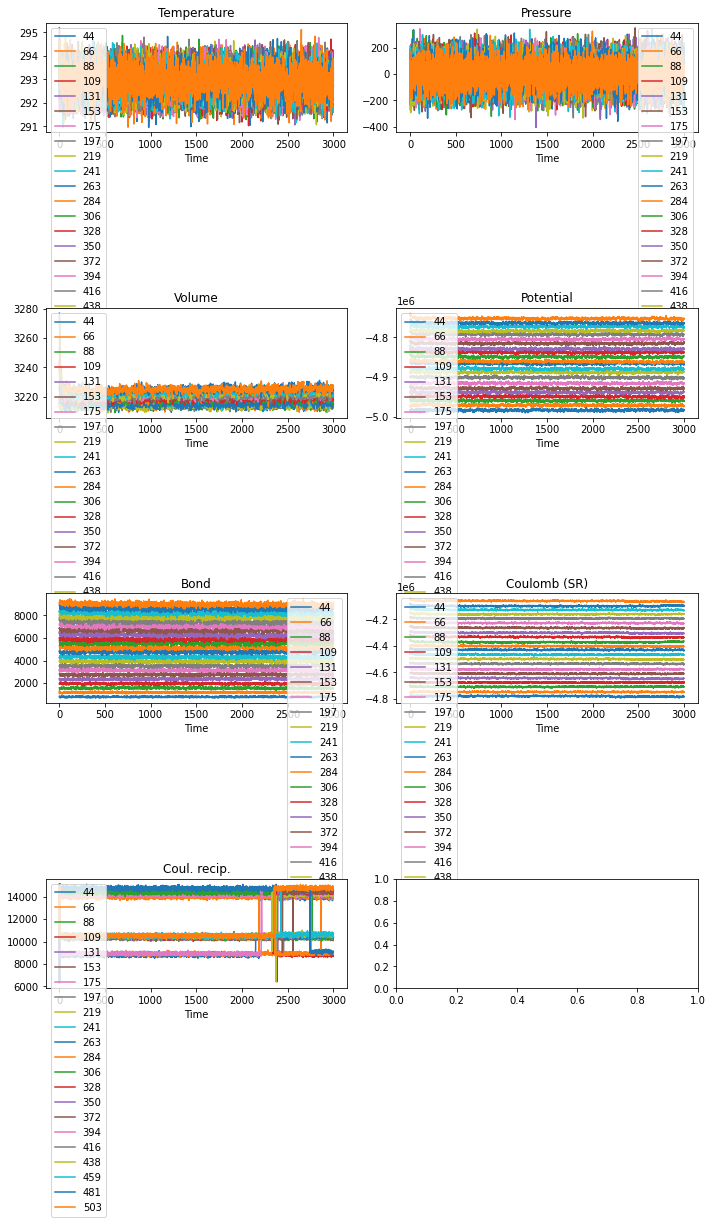

In [36]:
#n = len(res_df['nmolecules'].unique())
y_quantities = [
    'Temperature',
    'Pressure',
    'Volume',
    'Potential',
    'Bond',
    'Coulomb (SR)',
    'Coul. recip.',
    ]

n = len(y_quantities)
cols = 2
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
for key, grp in res_df.groupby(['nmolecules']):
    for y_quantity, position in zip(y_quantities, positions):
        grp.plot('Time',y_quantity,ax=ax[position],label=key,title=y_quantity)
        
fig.tight_layout()

### Visualize trajectory

In [37]:
query = {
    'metadata.project': project_id,
    'metadata.step': 'GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad',
    'metadata.type': 'mp4_file',
}

In [38]:
# use underlying MongoDB functionality to check total number of documents matching query
fp.filepad.count_documents(query)

17

In [39]:
parameter_dict = {'nmolecules': 'metadata.system.surfactant.nmolecules'}

aggregation_pipeline = [
    {
        "$match": query
    },
    {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    },
    { 
        "$group": { 
            "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
            "degeneracy": {"$sum": 1}, # number matching data sets
            "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
        }
    },
    {
        "$sort": { 
            "_id.nmolecules": pymongo.DESCENDING,
        }
    },
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

obj_dict = {}
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    # print(metadata['metadata'])
    with tempfile.NamedTemporaryFile(suffix='.mp4',delete=False) as tmp:
        tmp.write(content)
        # obj_list.append(Video(filename=tmp.name)) 
        # obj_list.append(tmp.name)
        key = tuple(c["_id"].values())
        obj_dict.update({key: Video.from_file(tmp.name)})
    print('.',end='')

.................

In [40]:
for key, obj in obj_dict.items():
    print(key)
    display(obj)

(503,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x05mW\x00mdat\x00\x00\…

(481,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x05\x85g\x81mdat\x00\x…

(459,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x05\x96\x86\xddmdat\x0…

(438,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x05\x84\xbc=mdat\x00\x…

(416,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x05)\xdf.mdat\x00\x00\…

(394,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x05TH\xe8mdat\x00\x00\…

(372,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x05\x02X\x93mdat\x00\x…

(328,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04\x8f\xc0\tmdat\x00\…

(306,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04\xe6\xc2\xf6mdat\x0…

(284,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04\xd8\xf5\xedmdat\x0…

(263,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04\xd4\xc1\x89mdat\x0…

(241,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04\x9f\x11\x9dmdat\x0…

(219,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04\xf2\x11\nmdat\x00\…

(197,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04\x81\x13\x89mdat\x0…

(175,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x04V"-mdat\x00\x00\x02…

(153,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x03yC\xbcmdat\x00\x00\…

(131,)


Video(value=b'\x00\x00\x00 ftypisom\x00\x00\x02\x00isomiso2avc1mp41\x00\x00\x00\x08free\x03\x93\xe7\xb4mdat\x0…


### Pre-evaluated RDF

#### Overview

In [170]:
query = { 
    "metadata.project": project_id,
    "metadata.type": {'$regex': '.*rdf$'},
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [171]:
# check files degenerate by 'metadata.type' ad 'metadata.name'
aggregation_pipeline = [
    {
        "$match": query
    },
    {  # group by unique project id
        "$group": { 
            "_id": { 
                'type': '$metadata.type',
            },
            "object_count": {"$sum": 1}, # count matching data sets
            "earliest":  {'$min': '$metadata.datetime' },
            "latest":  {'$max': '$metadata.datetime' },
        },
    },
    {  # sort by earliest date, descending
        "$sort": { 
            "earliest": pymongo.DESCENDING,
        }
    }
]

cursor = fp.filepad.aggregate(aggregation_pipeline)

res = [ {**c['_id'], **c} for c in cursor]
columns = ['type', 'earliest', 'latest', 'object_count', '_id']
res_df = pd.DataFrame(data=res, columns=columns) # pandas Dataframe is just nice for printing in notebook
del res_df["_id"]

In [172]:
res_df

Empty DataFrame
Columns: [type, earliest, latest, object_count]
Index: []

#### Substrate - surfactant head RDF

In [173]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [174]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_head_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [175]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
aggregation_pipeline = [ match_aggregation, sort_aggregation, group_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [176]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Substrate - surfactant tail RDF

In [177]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [178]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_surfactant_tail_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [179]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [180]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
    
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant head - surfactant tail RDF

In [181]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [182]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_tail_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [183]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [184]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant head - counterion RDF

In [185]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [186]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'counterion_surfactant_head_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [187]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [188]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'],data['rdf'][0], label='First frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][len(data)//2],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'],data['rdf'][-1],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant head - surfactant head RDF

In [189]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [190]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_head_surfactant_head_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [191]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [192]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:],data['rdf'][0][cutoff_index_inner:], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:],data['rdf'][len(data)//2][cutoff_index_inner:],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:],data['rdf'][-1][cutoff_index_inner:],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Surfactant tail - surfactant tail RDF

In [193]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [194]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'surfactant_tail_surfactant_tail_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [195]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [196]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][0][cutoff_index_inner:cutoff_index_outer], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][len(data)//2][cutoff_index_inner:cutoff_index_outer],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][-1][cutoff_index_inner:cutoff_index_outer],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)

#### Substrate - substrate RDF

In [197]:
parameter_dict = {
    'nmolecules': 'metadata.system.surfactant.nmolecules'}

In [198]:
query = { 
    "metadata.project": project_id,
    "metadata.type": 'substrate_substrate_rdf',
    "metadata.step": "GromacsRelaxation:ProcessAnalyzeAndVisualize:push_filepad",
}

fp.filepad.count_documents(query)

0

In [199]:
res_dict = {}
failed_list = []

match_aggregation = {
        "$match": query
    }
sort_aggregation = {
        "$sort": { 
            "metadata.datetime": pymongo.DESCENDING,
        }
    }
group_aggregation = { 
    "$group": { 
        "_id": { field: '${}'.format(key) for field, key in parameter_dict.items() },
        "degeneracy": {"$sum": 1}, # number matching data sets
        "latest":     {"$first": "$gfs_id"} # unique gridfs id of file
    }
}
second_sort_aggregation = {
    "$sort": { 
        "_id.nmolecules": pymongo.DESCENDING,
    }
}


aggregation_pipeline = [ 
    match_aggregation, sort_aggregation, group_aggregation, second_sort_aggregation ]
cursor = fp.filepad.aggregate(aggregation_pipeline)

# res_list = []
for i, c in enumerate(cursor): 
    content, metadata = fp.get_file_by_id(c["latest"])
    nmolecules = int(c["_id"]["nmolecules"])
    data_str = io.StringIO(content.decode())
    data = np.loadtxt(data_str, comments='#')
    d = data[0] # distance bins
    rdf = data[1:]
    res_dict[nmolecules] = {'dist': d, 'rdf': rdf}
    # res_list.append(data)
    print('.',end='')
print('')

In [200]:
n = len(res_dict)
cols = 2 if n > 1 else 1
rows = round(n/cols)
cutoff_index_inner = 1
cutoff_index_outer = -1
if rows > 1:
    positions = [(i,j) for i in range(rows) for j in range(cols)][:n]
else:
    positions = [i for i in range(cols)][:n]
    
fig, ax = plt.subplots(rows,cols,figsize=(5*cols,4*rows))
if not isinstance(ax, Iterable):
    ax = [ax]
# for key, grp in res_df.groupby(['nmolecules']):
for pos, (nmolecules, data) in zip(positions, res_dict.items()):
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][0][cutoff_index_inner:cutoff_index_outer], label='First frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][len(data)//2][cutoff_index_inner:cutoff_index_outer],label='Intermediate frame RDF')
    ax[pos].plot(data['dist'][cutoff_index_inner:cutoff_index_outer],data['rdf'][-1][cutoff_index_inner:cutoff_index_outer],label='Last frame RDF')
    ax[pos].set_title(nmolecules)
    ax[pos].legend()

fig.tight_layout()
# fig.legend()
fig.show()

ValueError: figure size must be positive finite not (5, 0)